# Fitbit Data Analysis - Complete Enhanced Version with Detailed Explanations

This analysis processes Fitbit data to predict whether users will reach their daily step goals. Below is a comprehensive breakdown of each step with detailed comments and explanations.

## Step 1: Install and Import Required Packages

In [223]:
print("STEP 1: Installing and importing required packages...")

STEP 1: Installing and importing required packages...


In [224]:
# Install necessary packages if not already installed
%pip install pandas matplotlib seaborn networkx scikit-learn imbalanced-learn numpy tqdm

Note: you may need to restart the kernel to use updated packages.


In [225]:
# Import all required libraries
import pandas as pd  # For data manipulation and analysis
import glob  # For file path pattern matching
import os  # For operating system interactions
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For statistical data visualization
import networkx as nx  # For network/graph analysis
import numpy as np  # For numerical operations
from sklearn.ensemble import RandomForestClassifier  # Machine learning model
from sklearn.metrics import (accuracy_score, classification_report,
                            confusion_matrix, precision_recall_fscore_support,
                            precision_recall_curve, roc_curve,
                            auc, precision_score,
                            recall_score, f1_score)  # Model evaluation metrics
from imblearn.over_sampling import SMOTE  # For handling class imbalance
from sklearn.model_selection import train_test_split  # For data splitting
from sklearn.dummy import DummyClassifier  # For baseline model comparison
from tqdm.auto import tqdm
from sklearn import set_config

In [226]:
print("All packages successfully imported!\n")

All packages successfully imported!



Explanation:

- This step ensures all required Python packages are installed and imported
- Key packages include:
    - pandas for data manipulation
    - matplotlib and seaborn for visualization
    - scikit-learn for machine learning
    - imbalanced-learn for handling class imbalance
- The print statements provide clear feedback about the process

## Step 2: Load and Prepare Data

In [227]:
print("STEP 2: Loading and preparing data...")

STEP 2: Loading and preparing data...


In [228]:
# Set path to data directory and find all CSV files
path = "../datas/Data Coaching Fitbit/"
files = glob.glob(os.path.join(path, "*.csv"))
print(f"Found {len(files)} CSV files in directory")

Found 7 CSV files in directory


In [229]:
# Initialize empty list to store DataFrames
dfs = []

In [230]:
# Process each file
for file in files:
    print(f"Processing file: {os.path.basename(file)}")

    # Read CSV file
    df = pd.read_csv(file)

    # Convert date column to datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Filter data - keep only weekdays (Monday-Friday)
    df = df[df['date'].dt.weekday < 5]

    # Filter data - keep only records before 18:00
    df = df[df['date'].dt.hour <= 18]

    # Add processed DataFrame to list
    dfs.append(df)

Processing file: 1119.csv
Processing file: 1120.csv
Processing file: 1121.csv
Processing file: 1122.csv
Processing file: 1123.csv
Processing file: 1124.csv
Processing file: 1125.csv


In [231]:
# Combine all DataFrames into one
df = pd.concat(dfs, ignore_index=True)

In [232]:
# Print comprehensive data summary
print("\n" + "="*50)
print("DATA SUMMARY".center(50))
print("="*50)


                   DATA SUMMARY                   


In [233]:
# Basic dataset information
print(f"\nFinal Dataset Shape: {df.shape[0]} rows x {df.shape[1]} columns")


Final Dataset Shape: 1044240 rows x 8 columns


In [234]:
# Display data samples
print("\nFirst 5 rows:")
print(df.head().to_string())
print("\nLast 5 rows:")
print(df.tail().to_string())


First 5 rows:
   treatment_id  fitbit_id                date  calories  mets  level  steps  distance
0          1119        329 2014-12-01 00:00:00    1.3822    10      0    0.0       0.0
1          1119        329 2014-12-01 00:01:00    1.3822    10      0    0.0       0.0
2          1119        329 2014-12-01 00:02:00    1.3822    10      0    0.0       0.0
3          1119        329 2014-12-01 00:03:00    1.3822    10      0    0.0       0.0
4          1119        329 2014-12-01 00:04:00    1.3822    10      0    0.0       0.0

Last 5 rows:
         treatment_id  fitbit_id                date  calories  mets  level  steps  distance
1044235          1125        328 2015-03-19 18:55:00   9.08136    72      3  110.0   0.08492
1044236          1125        328 2015-03-19 18:56:00   8.57684    68      3  103.0   0.07952
1044237          1125        328 2015-03-19 18:57:00   8.82910    70      3  108.0   0.08338
1044238          1125        328 2015-03-19 18:58:00   8.82910    70      3  

In [235]:
# Data types information
print("\nData Types:")
print(df.dtypes.to_string())


Data Types:
treatment_id             int64
fitbit_id                int64
date            datetime64[ns]
calories               float64
mets                     int64
level                    int64
steps                  float64
distance               float64


In [236]:
# Statistical summary
print("\nStatistical Summary:")
print(df.describe(include='all').to_string())


Statistical Summary:
       treatment_id     fitbit_id                           date      calories          mets         level         steps      distance
count  1.044240e+06  1.044240e+06                        1044240  1.044240e+06  1.044240e+06  1.044240e+06  1.043100e+06  1.044240e+06
mean   1.121622e+03  3.305480e+02  2015-03-30 13:06:26.593886464  1.709672e+00  1.457896e+01  2.283623e-01  6.323363e+00  4.767763e-03
min    1.119000e+03  3.230000e+02            2014-12-01 00:00:00  5.526785e-01  4.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    1.120000e+03  3.250000e+02            2015-02-04 13:34:00  1.017400e+00  1.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00
50%    1.121000e+03  3.270000e+02            2015-03-23 21:29:30  1.271700e+00  1.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00
75%    1.123000e+03  3.290000e+02            2015-05-26 15:11:15  1.391800e+00  1.200000e+01  0.000000e+00  0.000000e+00  0.000000e+00
max    1.125000e+03  3.490000e+02

In [237]:
def get_missing_values(dt_frame):
    # Missing values analysis
    missing_values = dt_frame.isnull().sum()
    missing_pct = (missing_values / len(dt_frame)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage (%)': missing_pct.round(2)
    })
    print("\nMissing Values Analysis:")
    print(missing_info[missing_info['Missing Values'] > 0].sort_values('Percentage (%)', ascending=False).to_string())

    print(f"\nMissing Values in total: {missing_values.sum()}")

    # Return True if there is some missing value, else False
    return missing_values.sum() > 0

In [238]:
while get_missing_values(df):

    # Remove rows with missing values
    df.dropna(inplace=True)


Missing Values Analysis:
       Missing Values  Percentage (%)
steps            1140            0.11

Missing Values in total: 1140

Missing Values Analysis:
Empty DataFrame
Columns: [Missing Values, Percentage (%)]
Index: []

Missing Values in total: 0


In [239]:
# Duplicates analysis
duplicates = df.duplicated().sum()
duplicate_pct = (duplicates / len(df)) * 100
print(f"\nDuplicate Rows: {duplicates} ({duplicate_pct:.2f}%)")


Duplicate Rows: 0 (0.00%)


In [240]:
# Column list
print("\nColumns:")
for i, col in enumerate(df.columns, 1):
    print(f"{i}. {col}")


Columns:
1. treatment_id
2. fitbit_id
3. date
4. calories
5. mets
6. level
7. steps
8. distance


In [241]:
print("\nData preparation complete!\n")


Data preparation complete!



Key Data Preparation Steps:

1. Load multiple CSV files from the specified directory

2. Convert date strings to datetime objects

3. Filter to keep only weekday data (Monday-Friday)

4. Filter to keep only records before 6 PM

5. Combine all individual DataFrames into one

6. Perform comprehensive data quality checks:

    - Shape and size verification
    - Data type validation
    - Statistical summary
    - Missing value analysis
    - Duplicate detection

Data Quality Insights:

- Dataset contains over 1 million rows
- Only the 'steps' column has missing values (0.11%)
- No duplicate rows detected
- Data spans from December 2014 to July 2015

## Step 3: Exploratory Data Analysis

The EDA phase includes multiple visualizations to understand user activity patterns:

In [242]:
print("STEP 3: Performing exploratory data analysis...")

STEP 3: Performing exploratory data analysis...


### Plot 1: Individual Activity Analysis

In [243]:
def plot_person_data(treatment_id, df):
    """
    Plots activity metrics for a single person in a 2x2 grid

    Parameters:
    - treatment_id: ID of the user to plot
    - df: DataFrame containing the user's data

    Creates four subplots showing:
    1. Steps over time
    2. Calories burned over time
    3. Distance over time
    4. METs (Metabolic Equivalent of Task) over time
    """
    # Configuration for each subplot
    plot_config = [
        {'x': 'date', 'y': 'steps', 'type': 'line', 'color': None,
            'title': 'Steps Over Time', 'ylabel': 'Steps', 'xlabel': 'Date'},
        {'x': 'date', 'y': 'calories', 'type': 'line', 'color': 'red',
            'title': 'Calories Burned Over Time', 'ylabel': 'Calories', 'xlabel': 'Date'},
        {'x': 'date', 'y': 'distance', 'type': 'line', 'color': 'green',
            'title': 'Distance Over Time', 'ylabel': 'Distance (km)', 'xlabel': 'Date'},
        {'x': 'date', 'y': 'mets', 'type': 'line', 'color': 'purple',
            'title': 'METs Over Time', 'ylabel': 'METs', 'xlabel': 'Date'}
    ]

    # Create figure with appropriate subplot layout
    n_plots = len(plot_config)
    n_rows = int(np.ceil(n_plots / 2))
    fig, axes = plt.subplots(n_rows, min(2, n_plots), figsize=(12, 10))
    axes = axes.flatten() if n_plots > 1 else [axes]
    fig.suptitle(f'Activity Data for Person {treatment_id}')

    # Generate each subplot
    for ax, config in zip(axes, plot_config):
        ax.plot(df[config['x']], df[config['y']],
                marker=config.get('marker', 'o'),
                linestyle=config.get('linestyle', '-'),
                color=config.get('color'),
                label=config.get('label'))

        ax.set_title(config.get('title', ''))
        ax.set_xlabel(config.get('xlabel', ''))
        ax.set_ylabel(config.get('ylabel', ''))

        if 'xticklabels' in config:
            ax.set_xticklabels(config['xticklabels'], rotation=45)

        if config.get('legend'):
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Plotting data for user 1119


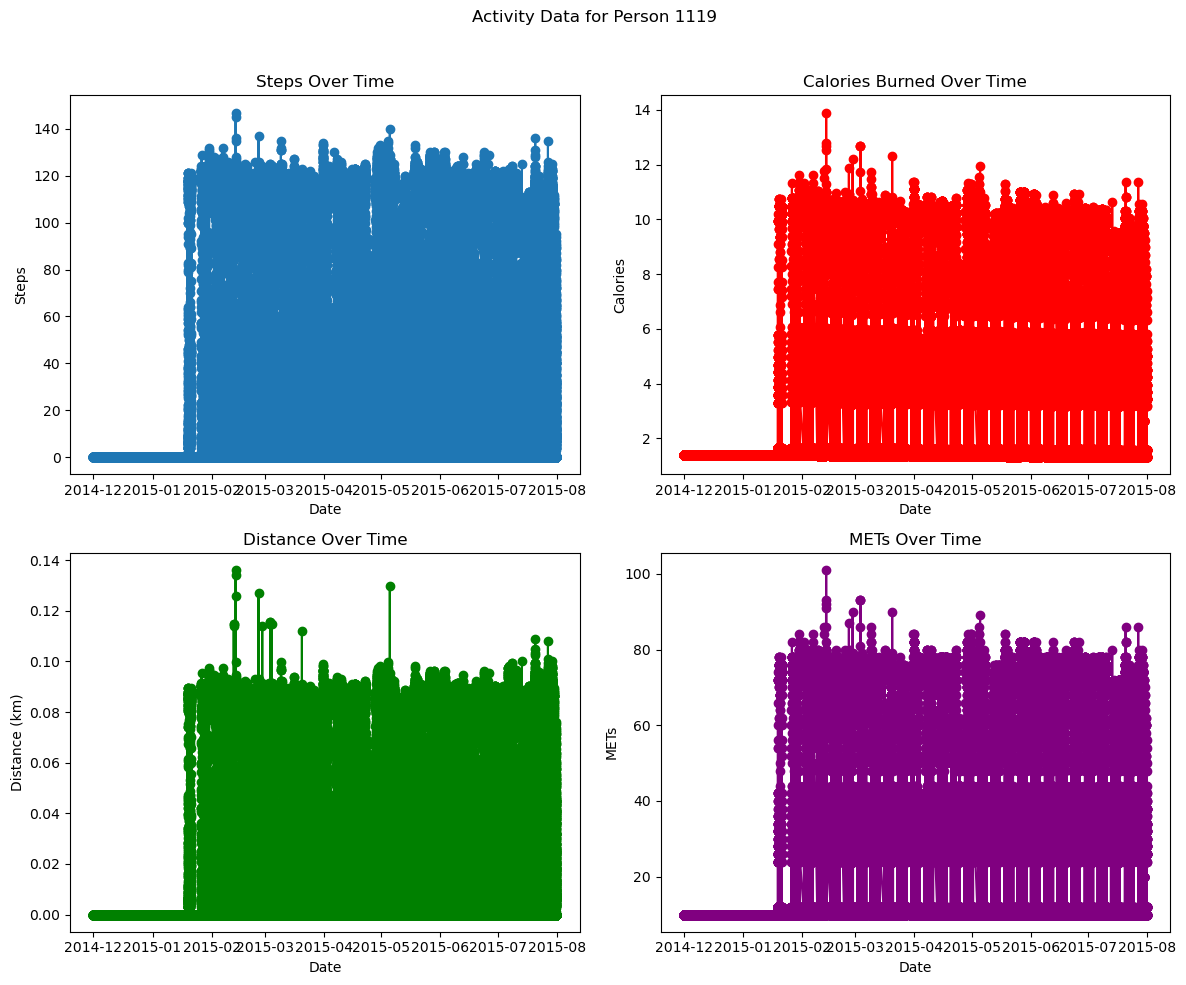

Plotting data for user 1120


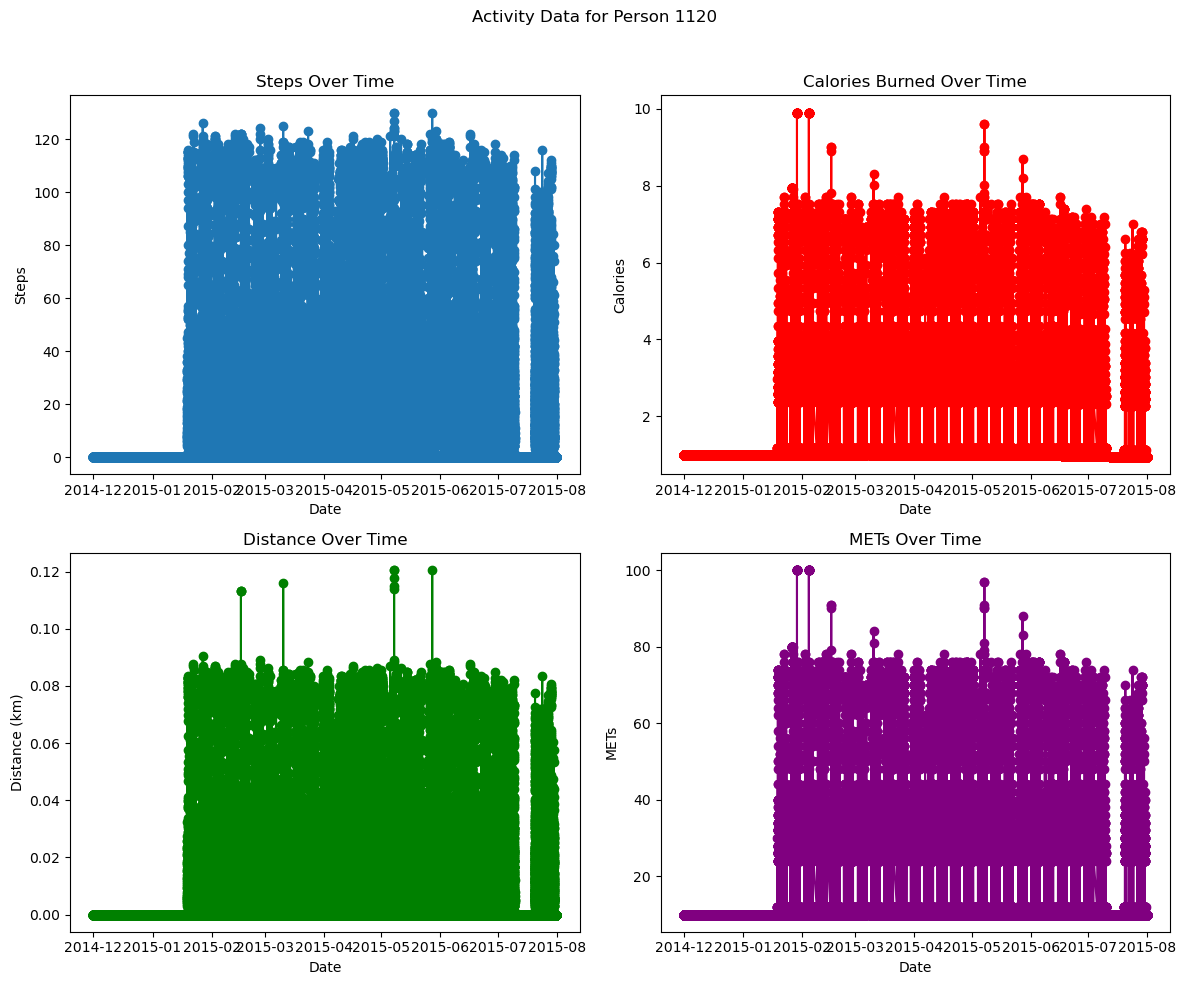

Plotting data for user 1121


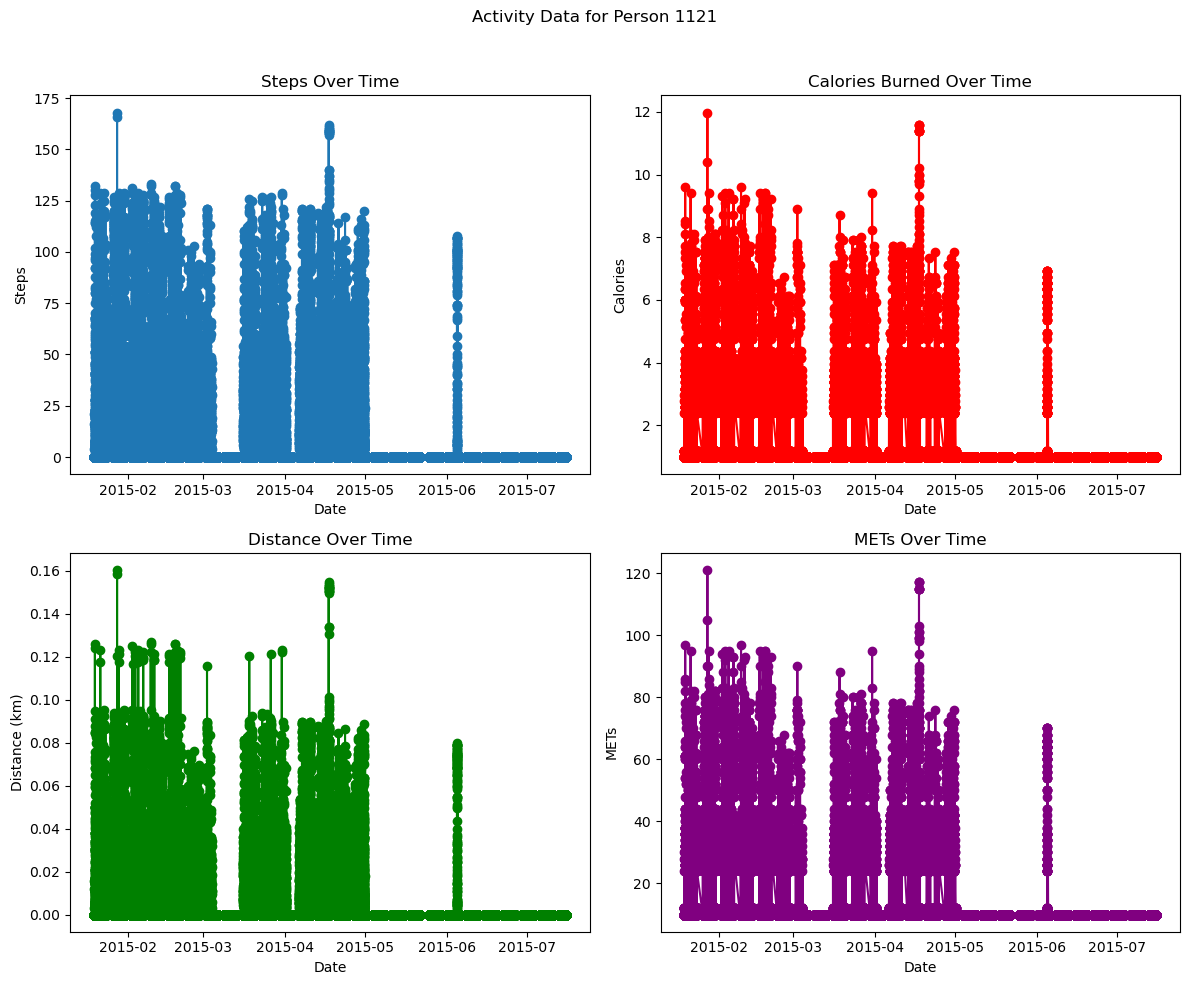

Plotting data for user 1122


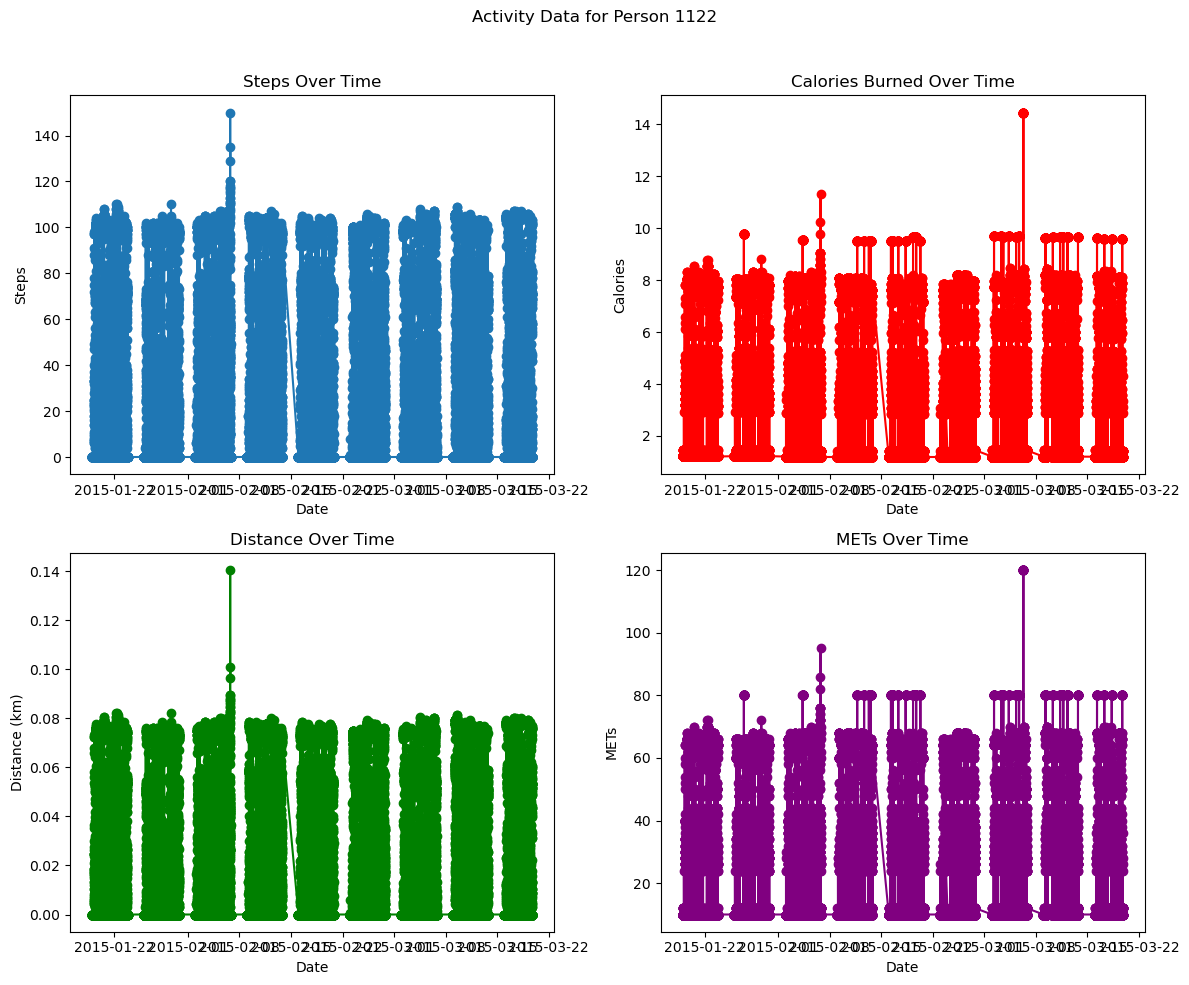

Plotting data for user 1123


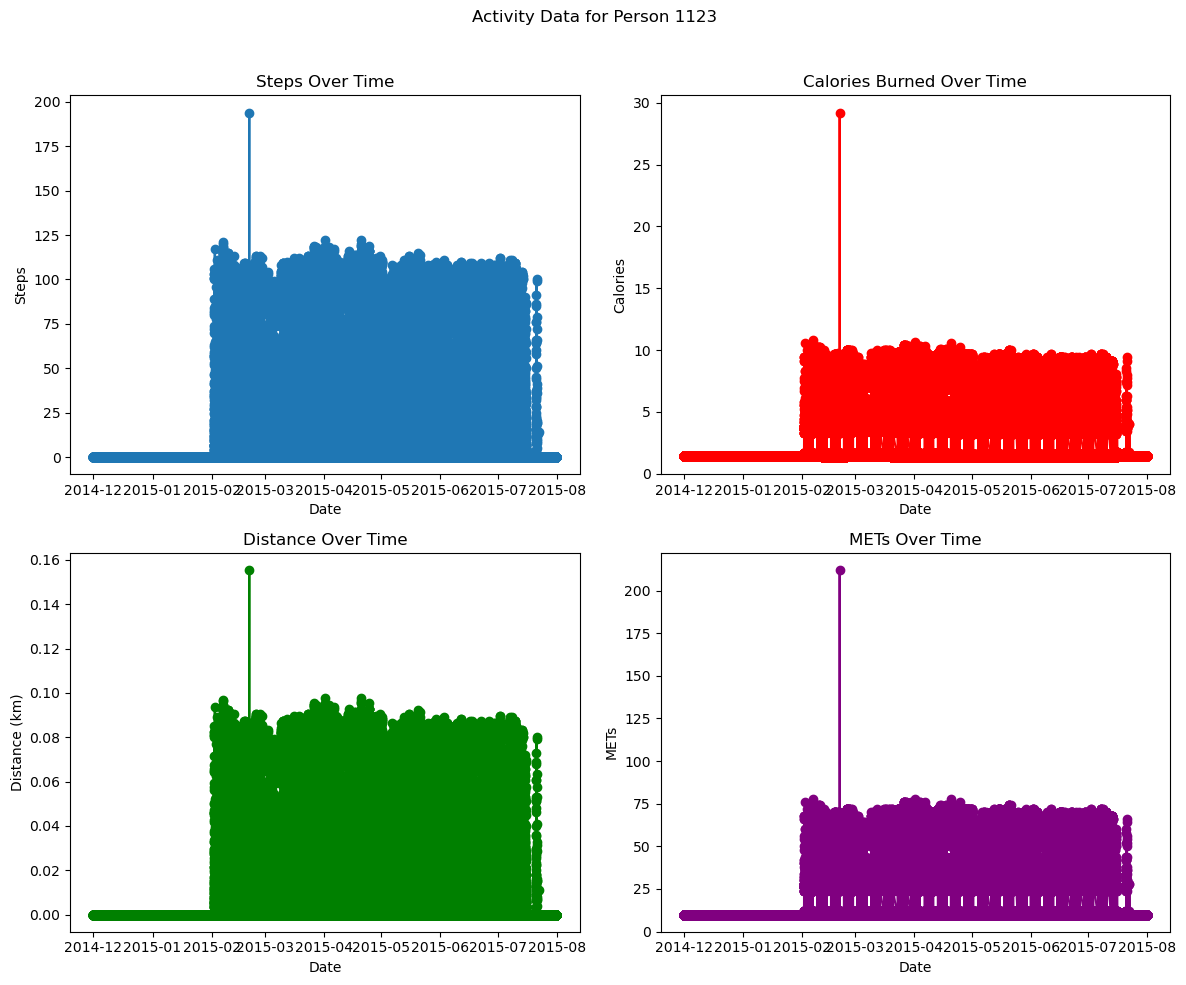

Plotting data for user 1124


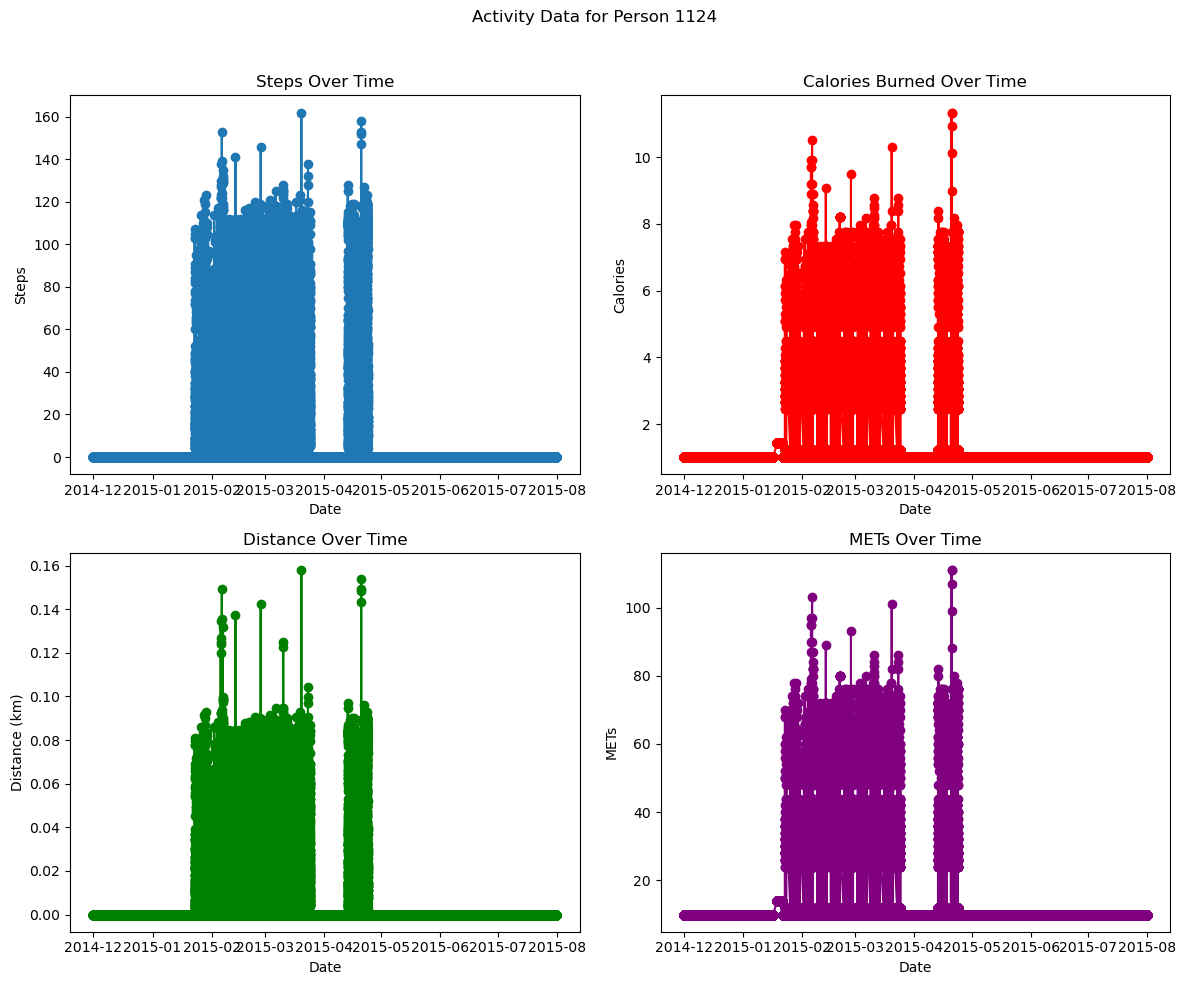

Plotting data for user 1125


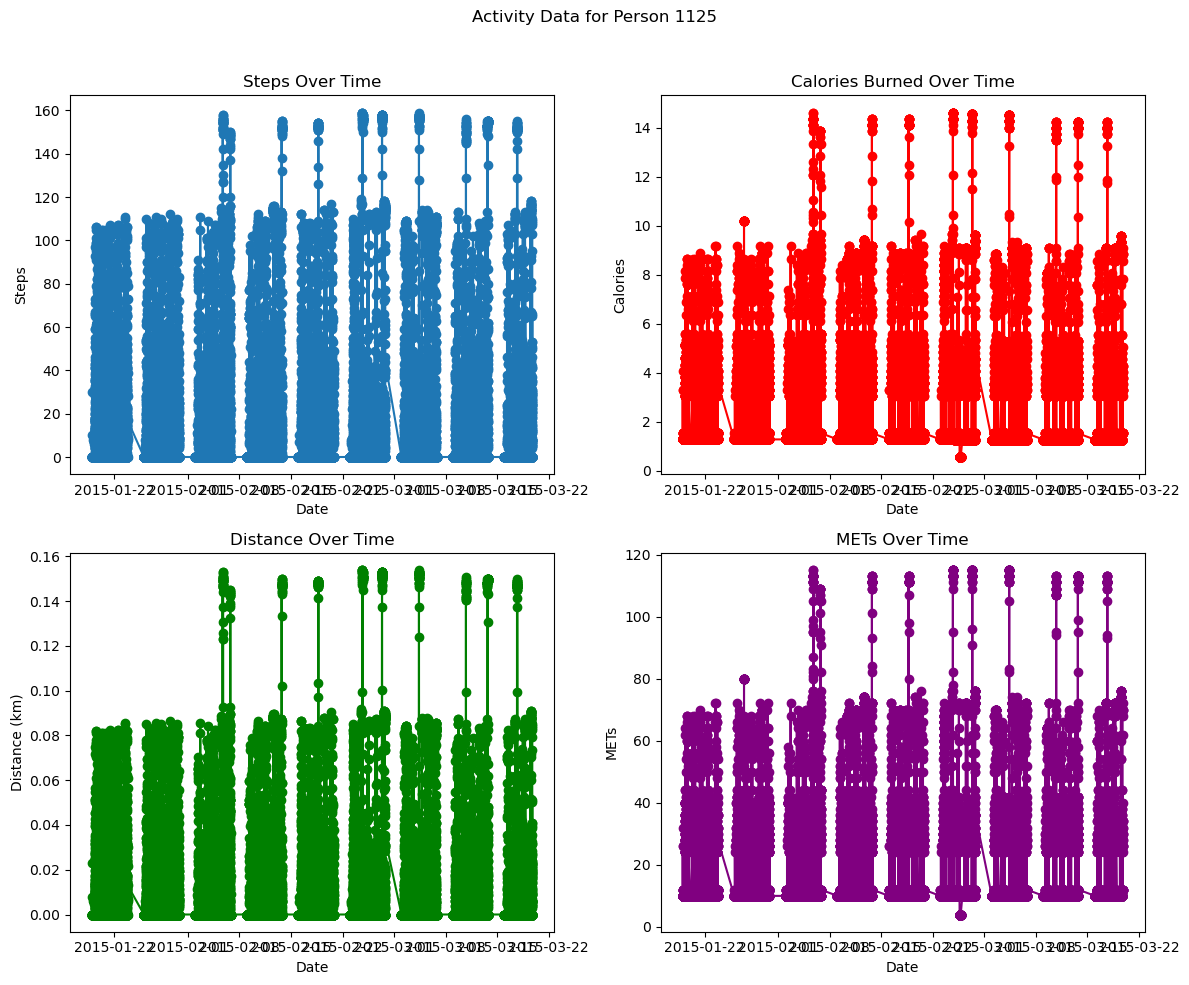

In [244]:
# Generate plots for each user
for treatment_id, person_df in df.groupby("treatment_id"):
    print(f"Plotting data for user {treatment_id}")
    plot_person_data(treatment_id, person_df)

Insights from Individual Plots:

- Each user shows unique activity patterns
- Some users have consistent activity levels while others show more variability
- Step counts and calorie burn are strongly correlated
- Most activity occurs during daytime hours

### Plot 2: Group Comparison

In [245]:
def plot_group_comparison(df):
    """
    Compares average activity metrics across all users

    Parameters:
    - df: Combined DataFrame containing all user data

    Creates four bar charts showing:
    1. Average steps per user
    2. Average calories burned per user
    3. Average distance per user
    4. Average METs per user
    """
    # Calculate summary statistics by user
    df_summary = df.groupby("treatment_id").agg({
        "steps": "mean",
        "calories": "mean",
        "distance": "mean",
        "mets": "mean"
    }).rename(columns={
        "steps": "Avg Steps",
        "calories": "Avg Calories",
        "distance": "Avg Distance",
        "mets": "Avg METs"
    })

    # Plot configuration
    plot_config = [
        {'y': 'Avg Steps', 'type': 'bar', 'color': 'blue',
            'title': 'Average Steps', 'ylabel': 'Steps', 'xlabel': 'User ID'},
        {'y': 'Avg Calories', 'type': 'bar', 'color': 'red',
            'title': 'Average Calories', 'ylabel': 'Calories', 'xlabel': 'User ID'},
        {'y': 'Avg Distance', 'type': 'bar', 'color': 'green',
            'title': 'Average Distance', 'ylabel': 'Distance (km)', 'xlabel': 'User ID'},
        {'y': 'Avg METs', 'type': 'bar', 'color': 'purple',
            'title': 'Average METs', 'ylabel': 'METs', 'xlabel': 'User ID',
            'xticklabels': df_summary.index}
    ]

    # Create figure with subplots
    n_plots = len(plot_config)
    n_rows = int(np.ceil(n_plots / 2))
    fig, axes = plt.subplots(n_rows, min(2, n_plots), figsize=(12, 10))
    axes = axes.flatten() if n_plots > 1 else [axes]
    fig.suptitle("Comparison of Activity Metrics Across Users")

    # Generate each subplot
    for ax, config in zip(axes, plot_config):
        df_summary[config['y']].plot(kind='bar', ax=ax,
                                    color=config.get('color'),
                                    label=config.get('label'))

        ax.set_title(config.get('title', ''))
        ax.set_xlabel(config.get('xlabel', ''))
        ax.set_ylabel(config.get('ylabel', ''))
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

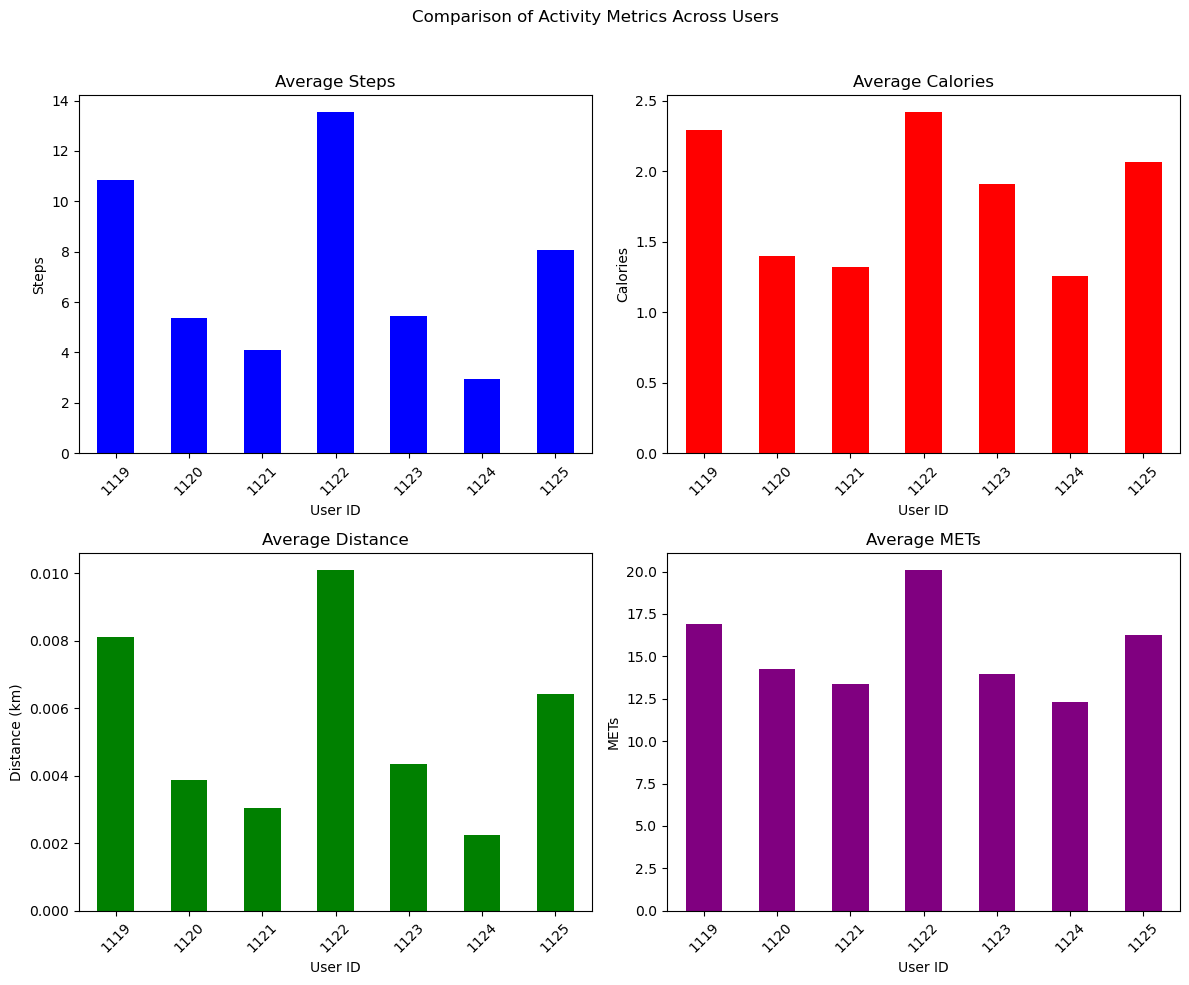

In [246]:
plot_group_comparison(df)

Group Comparison Insights:

- Significant variation in activity levels between users
- User 1122 shows highest average steps, calories, and distance
- User 1124 shows lowest activity metrics
- METs (intensity) follows similar pattern to step counts

### Plot 3: Individual means

In [247]:
def show_individual_mean_plots(data, treatment_column='treatment_id', date_column='date',
                                value_column='steps', fig_size=(12, 6),
                                title_prefix="Individual Mean Steps for Treatment",
                                x_label="Date", y_label="Average Steps",
                                rotate_xticks=45, ci=None):
    """
    Plots daily mean values for each treatment group with regression lines

    Parameters:
    - data: DataFrame containing the time series data
    - treatment_column: Column name containing treatment IDs
    - date_column: Column name containing dates
    - value_column: Column name containing values to plot (e.g., steps)
    - fig_size: Figure dimensions
    - title_prefix: Prefix for plot titles
    - x_label: Label for x-axis
    - y_label: Label for y-axis
    - rotate_xticks: Rotation angle for x-axis labels
    - ci: Confidence interval for regression plot
    """
    # Get unique treatment IDs
    treatment_ids = data[treatment_column].unique()

    for treatment in treatment_ids:
        print(f"Plotting data for treatment {treatment}")

        # Filter data for current treatment_id
        subset = data[data[treatment_column] == treatment].copy()

        # Convert date to numeric for regression
        subset.loc[:, 'date_numeric'] = (subset[date_column] - subset[date_column].min()).dt.days

        # Prepare x-ticks (first day of each month)
        months = pd.date_range(start=subset[date_column].min(),
                                end=subset[date_column].max(),
                                freq='MS')
        month_numeric = (months - subset[date_column].min()).days

        # Create figure
        fig, ax = plt.subplots(figsize=fig_size)

        # Plot regression line and scatter points
        sns.regplot(
            data=subset,
            x='date_numeric',
            y=value_column,
            scatter=True,
            ci=ci,
            label=f'Treatment {treatment}',
            ax=ax
        )

        # Set x-ticks
        ax.set_xticks(month_numeric)
        ax.set_xticklabels(months.strftime('%Y/%m'), rotation=rotate_xticks)

        # Set title and labels
        ax.set_title(f"{title_prefix} {treatment}")
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

        # Show legend
        ax.legend()

        plt.tight_layout()
        plt.show()

In [248]:
# Compute individual means for steps
individual_means = df.groupby(['treatment_id', df['date'].dt.date])['steps'].mean().reset_index()

In [249]:
# Convert 'date' back to datetime format
individual_means['date'] = pd.to_datetime(individual_means['date'])

In [250]:
treatment_ids = individual_means['treatment_id'].unique()

Plotting data for treatment 1119


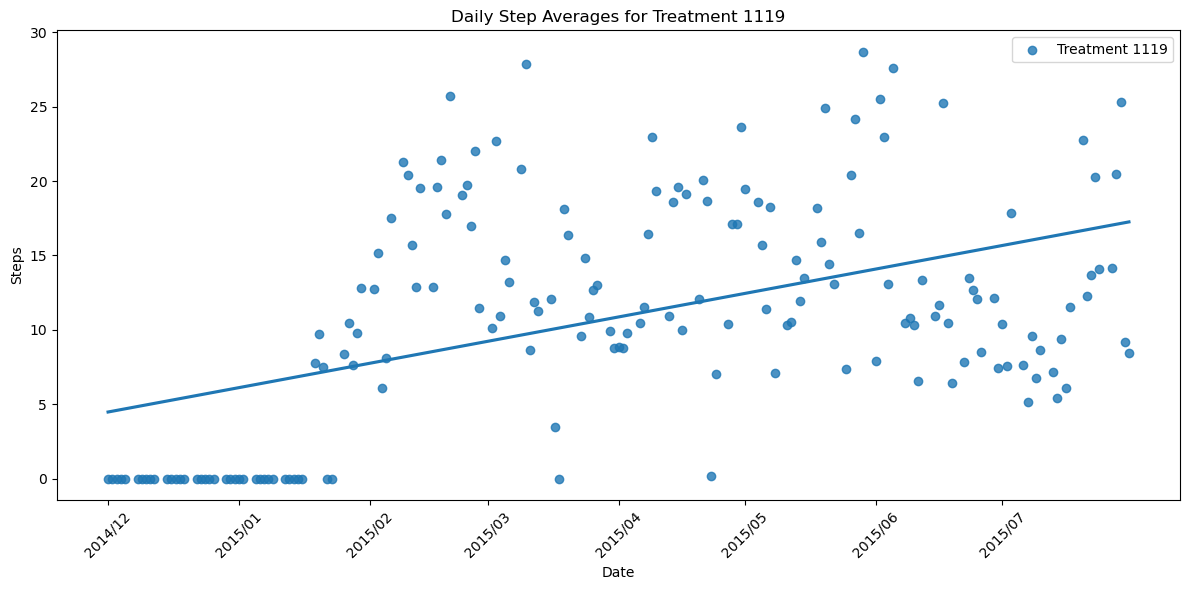

Plotting data for treatment 1120


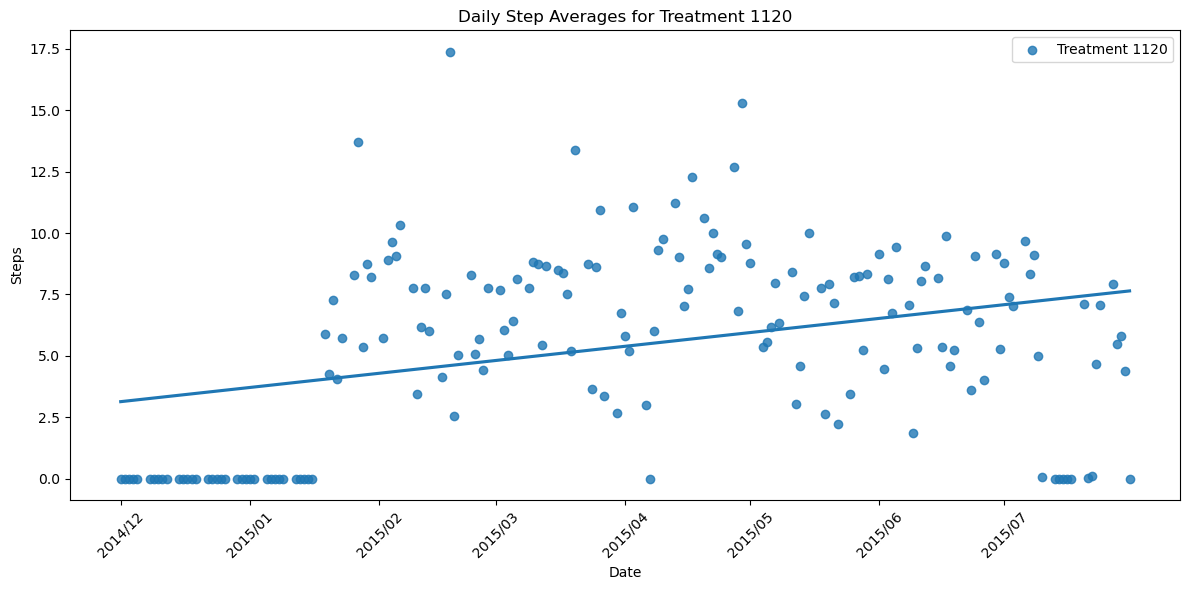

Plotting data for treatment 1121


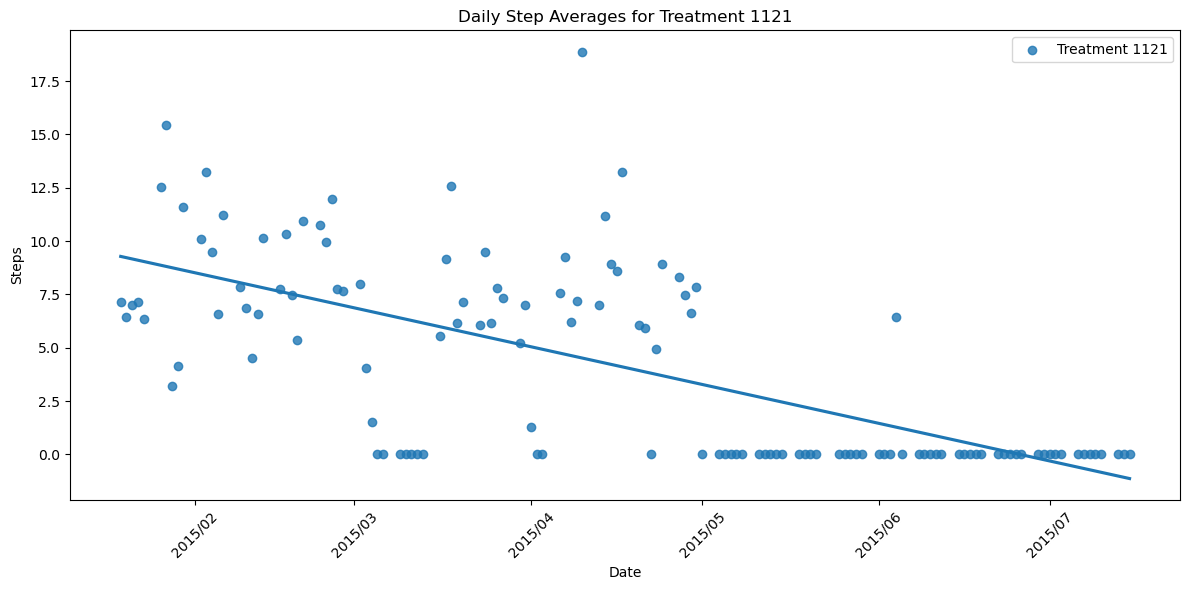

Plotting data for treatment 1122


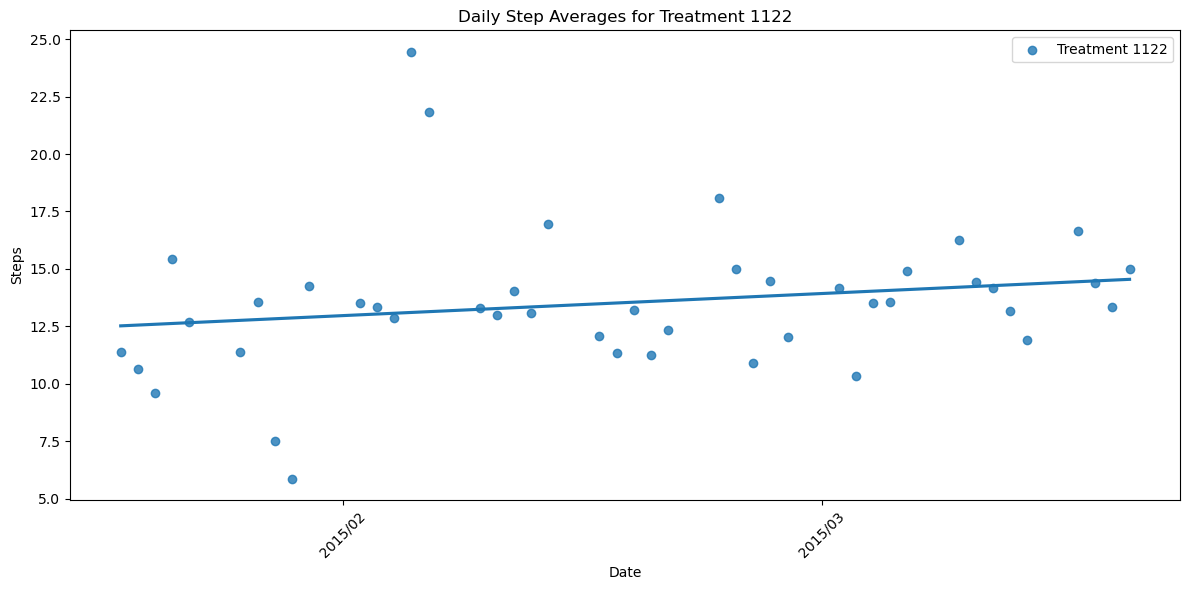

Plotting data for treatment 1123


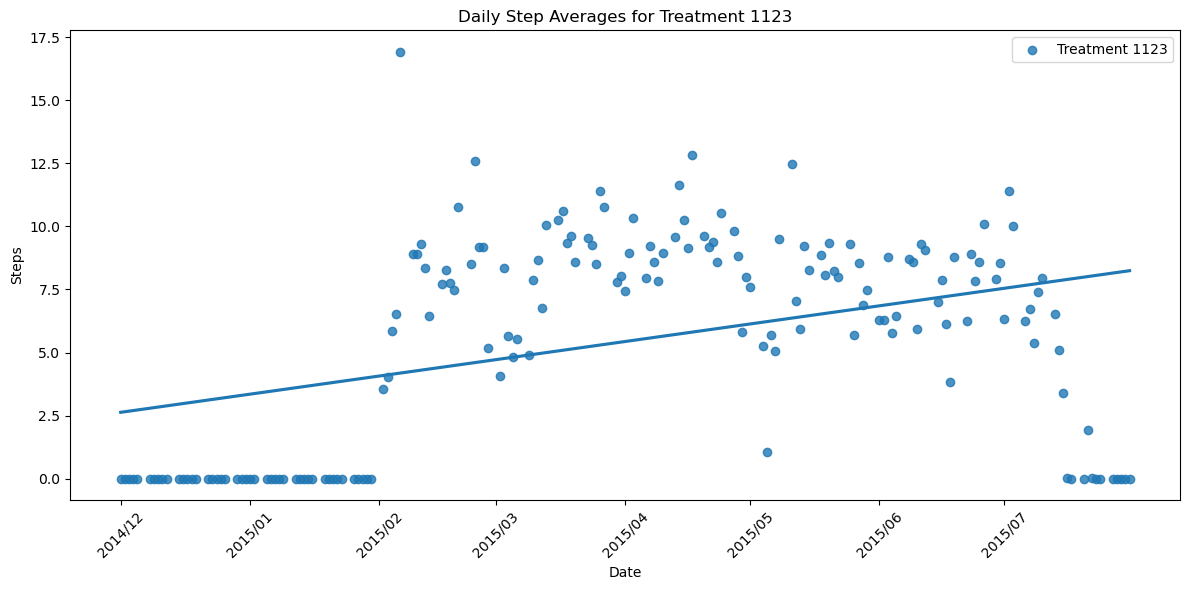

Plotting data for treatment 1124


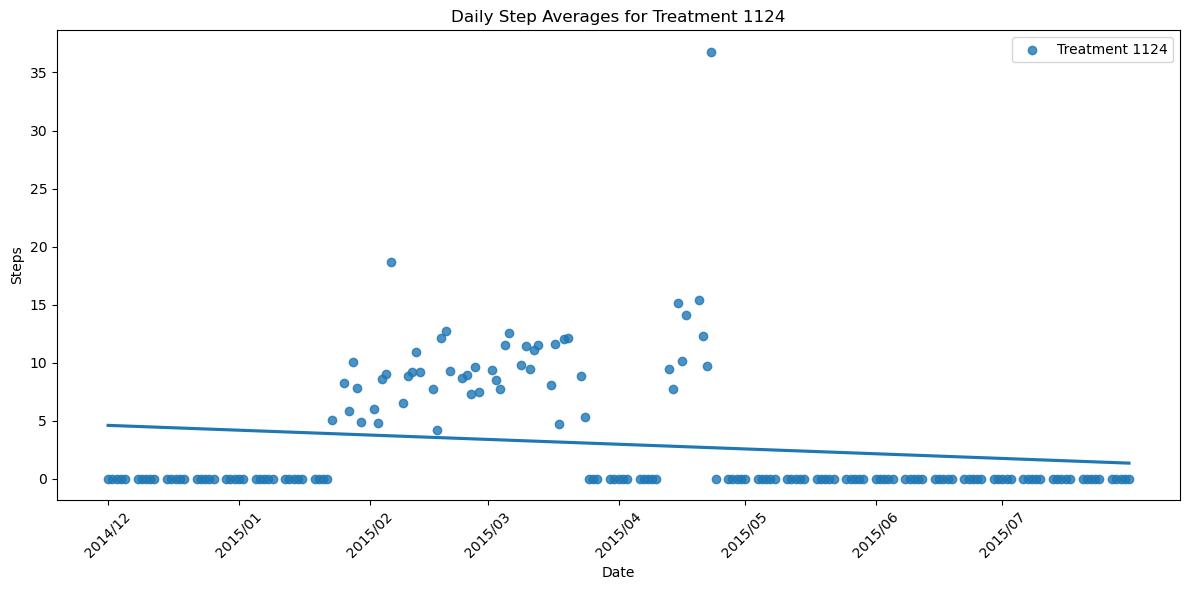

Plotting data for treatment 1125


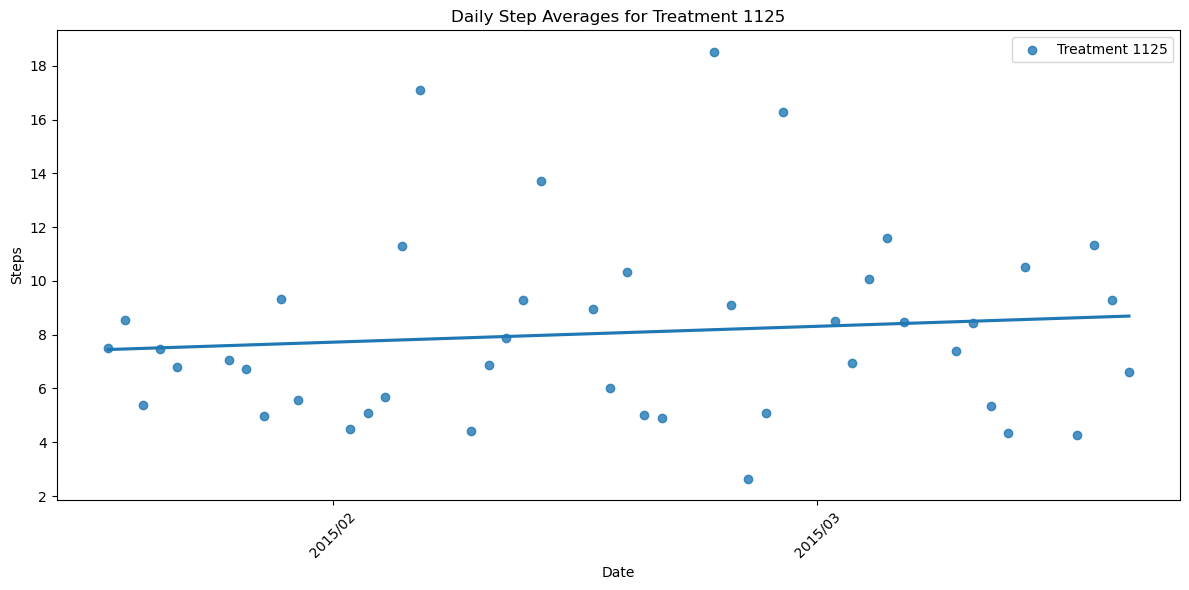

In [251]:
# Generate plots
show_individual_mean_plots(
    data=individual_means,
    treatment_column='treatment_id',
    date_column='date',
    value_column='steps',
    title_prefix="Daily Step Averages for Treatment",
    x_label="Date",
    y_label="Steps",
    rotate_xticks=45,
    ci=None
)

Individual Trends Insights:

- Most users show relatively stable step counts over time
- Some seasonal patterns visible (e.g., lower activity in winter months)
- No clear increasing or decreasing trends for most users
- User 1122 maintains consistently high activity levels

### Plot 4: Average steps

In [252]:
# Compute the average of all individuals' steps per day
average_steps = df.groupby([df['date'].dt.date])['steps'].mean().reset_index()

In [253]:
# Convert 'date' back to datetime format
average_steps['date'] = pd.to_datetime(average_steps['date'])

In [254]:
# Calculate and print the average number of steps
overall_avg_steps = average_steps['steps'].mean()
print(f"Average number of steps: {overall_avg_steps:.2f} by minute")
print(f"Average number of steps: {overall_avg_steps * 60:.2f} by hour")
print(f"Average number of steps: {overall_avg_steps * 60 * 24:.2f} by day")

Average number of steps: 5.77 by minute
Average number of steps: 346.11 by hour
Average number of steps: 8306.60 by day


In [255]:
def show_average_number_of_steps(average_steps_per_person, overall_avg_steps, time_unit='minutes', 
                                fig_size=(10, 6), title_prefix="Average number of steps", 
                                x_label="User ID", y_label="Average Steps", legend=True):
    """
    Plot average steps per person with a reference line showing the overall average.

    Parameters:
    -----------
    average_steps_per_person : pd.Series
        Series with index as user IDs and values as average steps
    overall_avg_steps : float
        The overall average steps value (per minute)
    time_unit : str ('minutes', 'hours', 'days')
        The time unit to calculate and display steps for
    fig_size : tuple
        Figure size (width, height)
    title_prefix : str
        Prefix for the plot title
    x_label : str
        Label for x-axis
    y_label : str
        Label for y-axis
    legend : bool
        Whether to show the legend
    """
    # Calculate multiplier and time unit label
    multipliers = {
        'minutes': 1,
        'hours': 60,
        'days': 60 * 24
    }

    if time_unit not in multipliers:
        raise ValueError(f"time_unit must be one of {list(multipliers.keys())}")

    multiplier = multipliers[time_unit]
    scaled_avg = overall_avg_steps * multiplier

    # Create figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Plot bar chart
    sns.barplot(
        x=average_steps_per_person.index,
        y=average_steps_per_person.values,
        ax=ax
    )

    # Add reference line
    ax.axhline(
        y=scaled_avg,
        color='red',
        linestyle='--',
        linewidth=1,
        label=f'Average steps: {scaled_avg:.1f}'
    )

    # Set title and labels
    ax.set_title(f"{title_prefix} by {time_unit} per person")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Rotate x-axis labels if many users
    if len(average_steps_per_person) > 10:
        plt.xticks(rotation=45)

    # Show legend if requested
    if legend:
        ax.legend()

    plt.tight_layout()
    plt.show()

In [256]:
# Calculate the average number of steps per person at 18:00 on a working day
average_steps_per_person = df.groupby('treatment_id')['steps'].mean()
print("Average number of steps by minutes per person at 18:00 on a working day:")
print(average_steps_per_person)

Average number of steps by minutes per person at 18:00 on a working day:
treatment_id
1119    10.864331
1120     5.387173
1121     4.116294
1122    13.529545
1123     5.436145
1124     2.957073
1125     8.067763
Name: steps, dtype: float64


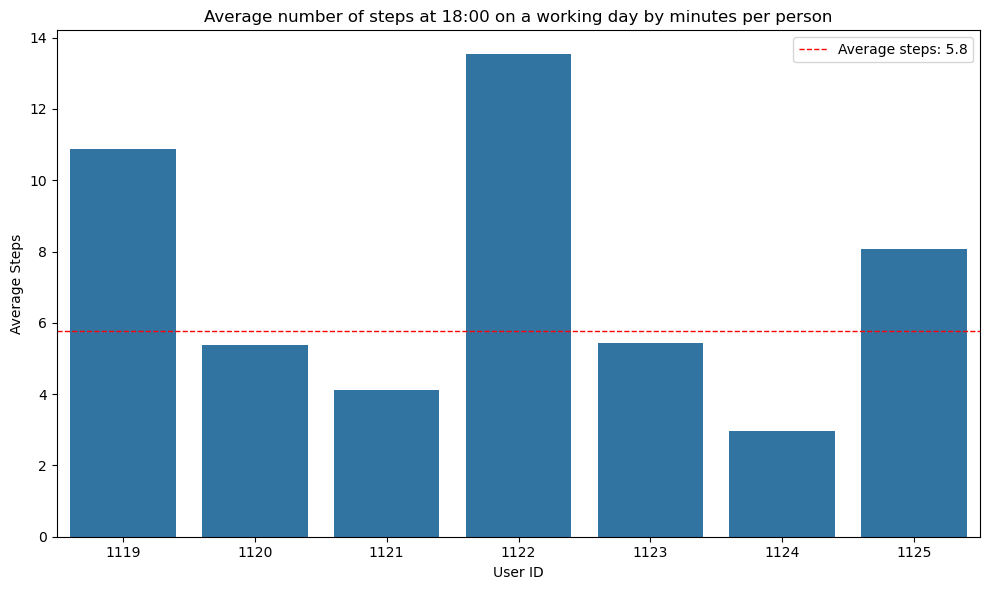

In [257]:
# For minutes
show_average_number_of_steps(
    average_steps_per_person=average_steps_per_person,
    overall_avg_steps=overall_avg_steps,
    time_unit='minutes',
    title_prefix="Average number of steps at 18:00 on a working day"
)

In [258]:
print("Average number of steps by hours per person at 18:00 on a working day:")
average_steps_per_person = average_steps_per_person * 60
print(average_steps_per_person)

Average number of steps by hours per person at 18:00 on a working day:
treatment_id
1119    651.859850
1120    323.230376
1121    246.977621
1122    811.772727
1123    326.168722
1124    177.424361
1125    484.065789
Name: steps, dtype: float64


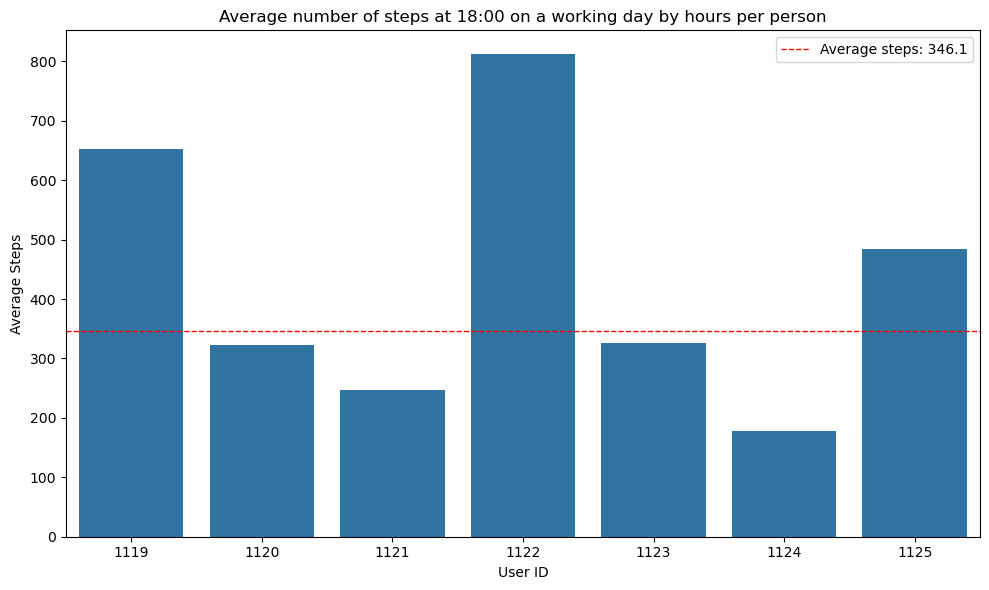

In [259]:
# For hours
show_average_number_of_steps(
    average_steps_per_person=average_steps_per_person,
    overall_avg_steps=overall_avg_steps,
    time_unit='hours',
    title_prefix="Average number of steps at 18:00 on a working day"
)

In [260]:
average_steps_per_person = average_steps_per_person * 24
print("Average number of steps by day per person at 18:00 on a working day:")
print(average_steps_per_person)

Average number of steps by day per person at 18:00 on a working day:
treatment_id
1119    15644.636391
1120     7757.529023
1121     5927.462909
1122    19482.545455
1123     7828.049323
1124     4258.184662
1125    11617.578947
Name: steps, dtype: float64


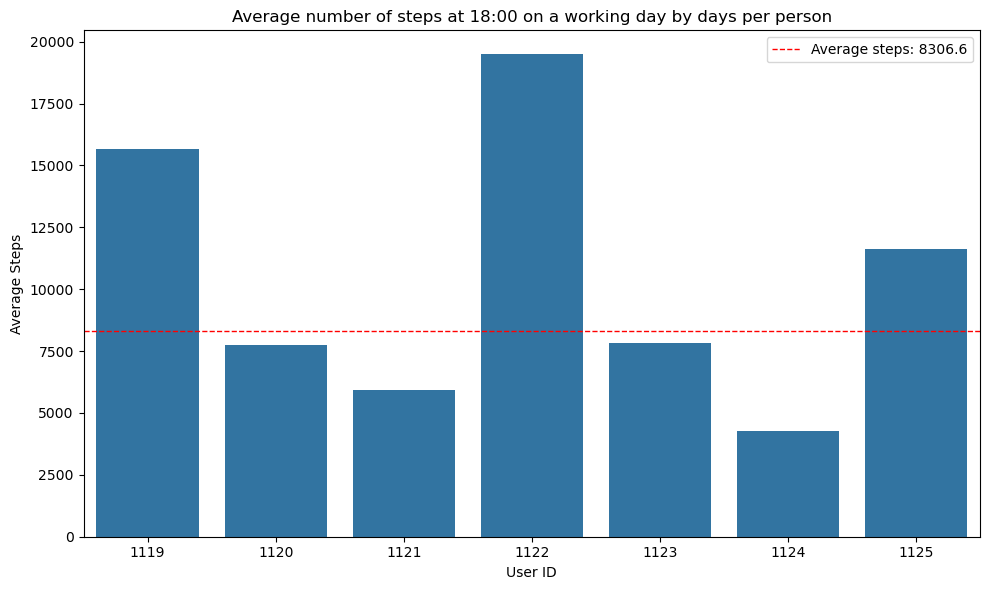

In [261]:
# For days
show_average_number_of_steps(
    average_steps_per_person=average_steps_per_person,
    overall_avg_steps=overall_avg_steps,
    time_unit='days',
    title_prefix="Average number of steps at 18:00 on a working day"
)

### Plot 5: Average steps for all treatment groups

In [262]:
def show_average_steps_trend(data, date_column='date', value_column='steps',
                            fig_size=(12, 6), title="Average Steps Trend",
                            x_label="Date", y_label="Average Steps",
                            rotate_xticks=45, ci=None, show_legend=True):
    """
    Plot average steps over time with regression line and monthly ticks.

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing the time series data
    date_column : str
        Column name containing dates
    value_column : str
        Column name containing the values to plot (e.g., steps)
    fig_size : tuple
        Figure size (width, height)
    title : str
        Plot title
    x_label : str
        Label for x-axis
    y_label : str
        Label for y-axis
    rotate_xticks : int
        Rotation angle for x-axis tick labels
    ci : int or None
        Confidence interval for regression plot
    show_legend : bool
        Whether to show the legend
    """
    # Make a copy to avoid modifying original dataframe
    plot_data = data.copy()

    # Convert date to numeric for regression
    plot_data['date_numeric'] = (plot_data[date_column] - plot_data[date_column].min()).dt.days

    # Prepare x-ticks (first day of each month)
    months = pd.date_range(
        start=plot_data[date_column].min(),
        end=plot_data[date_column].max(),
        freq='MS'
    )
    month_numeric = (months - plot_data[date_column].min()).days

    # Create figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Plot regression line and scatter points
    sns.regplot(
        data=plot_data,
        x='date_numeric',
        y=value_column,
        scatter=True,
        ci=ci,
        label='Average Steps',
        ax=ax
    )

    # Set x-ticks
    ax.set_xticks(month_numeric)
    ax.set_xticklabels(months.strftime('%Y/%m'), rotation=rotate_xticks)

    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Show legend if requested
    if show_legend:
        ax.legend()

    plt.tight_layout()
    plt.show()

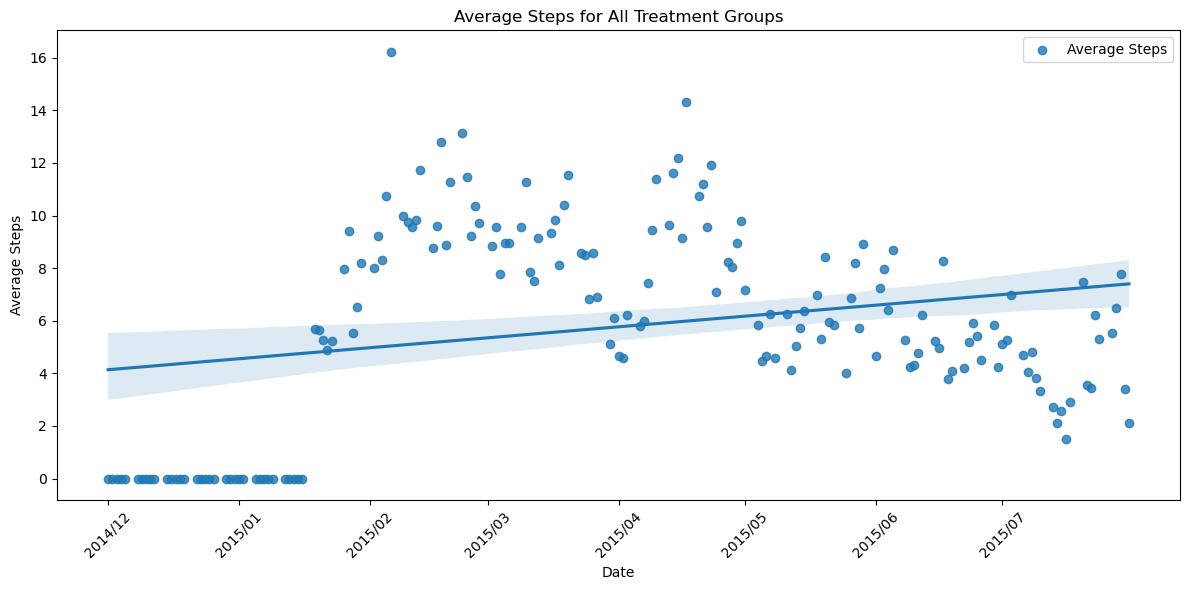

In [263]:
show_average_steps_trend(
    data=average_steps,
    date_column='date',
    value_column='steps',
    title="Average Steps for All Treatment Groups",
    x_label="Date",
    y_label="Average Steps",
    rotate_xticks=45,
    ci=95,
    show_legend=True
)

### Plot 6: Individual plots with average steps superposed

In [264]:
def show_treatment_with_reference(individual_data, average_data, treatment_id,
                                fig_size=(12, 6), title_prefix="Individual Mean Steps and Average",
                                x_label="Date", y_label="Average Steps", rotate_xticks=45):
    """
    Plot individual treatment data with average reference line.

    Parameters:
    -----------
    individual_data : pd.DataFrame
        DataFrame containing individual treatment data
    average_data : pd.DataFrame
        DataFrame containing average steps data
    treatment_id : str/int
        Treatment ID to plot
    fig_size : tuple
        Figure size (width, height)
    title_prefix : str
        Prefix for plot title
    x_label : str
        Label for x-axis
    y_label : str
        Label for y-axis
    rotate_xticks : int
        Rotation angle for x-axis tick labels
    """
    print(f"Plotting data for treatment {treatment_id}")

    # Filter and prepare data
    subset = individual_data[individual_data['treatment_id'] == treatment_id].copy()
    subset['date_numeric'] = (subset['date'] - subset['date'].min()).dt.days
    average_data = average_data.copy()
    average_data['date_numeric'] = (average_data['date'] - subset['date'].min()).dt.days

    # Prepare x-ticks
    months = pd.date_range(start=subset['date'].min(), end=subset['date'].max(), freq='MS')
    month_numeric = (months - subset['date'].min()).days

    # Create figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Plot treatment data (with scatter points)
    sns.regplot(
        data=subset,
        x='date_numeric',
        y='steps',
        scatter=True,
        ci=None,
        label=f'Treatment {treatment_id}',
        ax=ax
    )

    # Plot average reference line (dashed, no scatter)
    sns.regplot(
        data=average_data,
        x='date_numeric',
        y='steps',
        scatter=False,
        ci=95,
        label='Average Steps',
        line_kws={'color': 'black', 'linestyle': '--'},
        ax=ax
    )

    # Set x-ticks and labels
    ax.set_xticks(month_numeric)
    ax.set_xticklabels(months.strftime('%Y/%m'), rotation=rotate_xticks)

    # Set title and labels
    ax.set_title(f"{title_prefix} for Treatment {treatment_id}")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # Show legend
    ax.legend()

    plt.tight_layout()
    plt.show()

Plotting data for treatment 1119


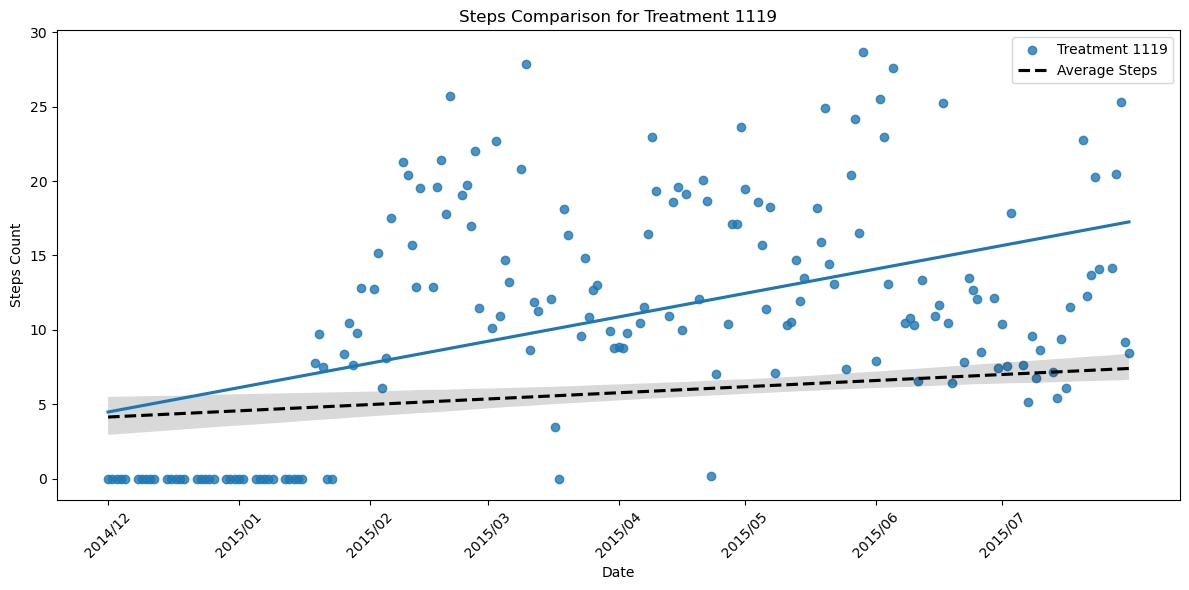

Plotting data for treatment 1120


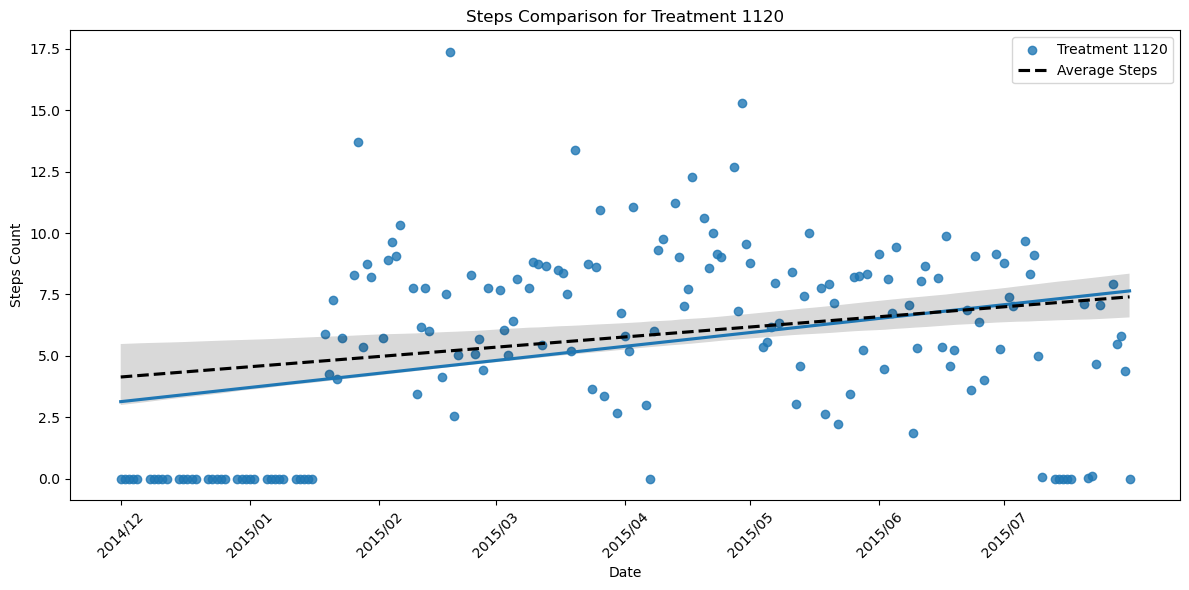

Plotting data for treatment 1121


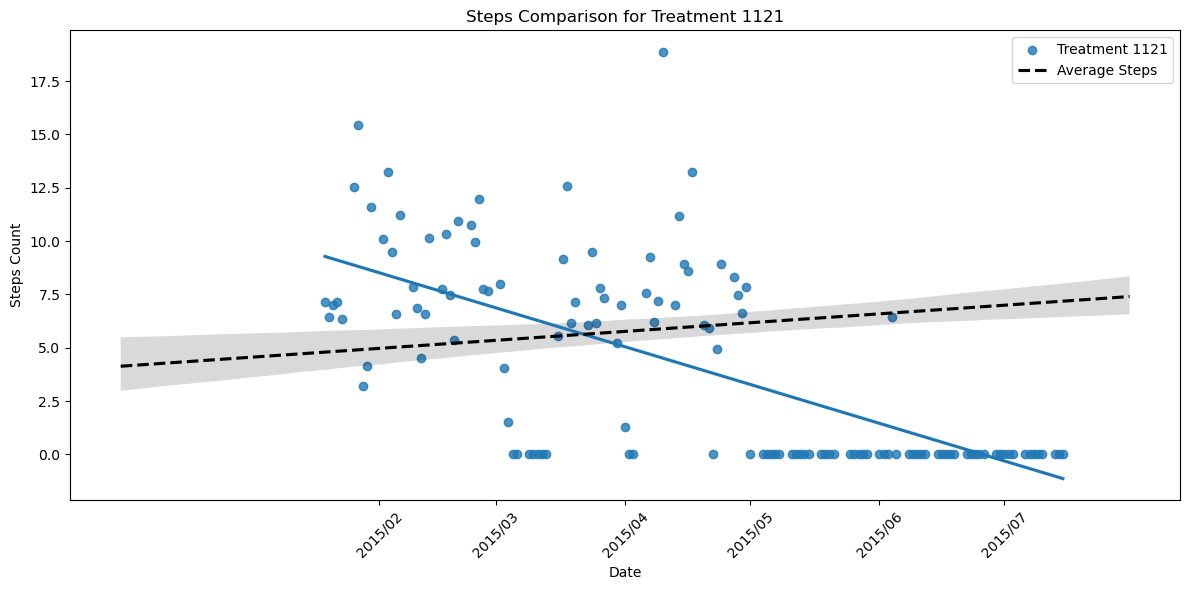

Plotting data for treatment 1122


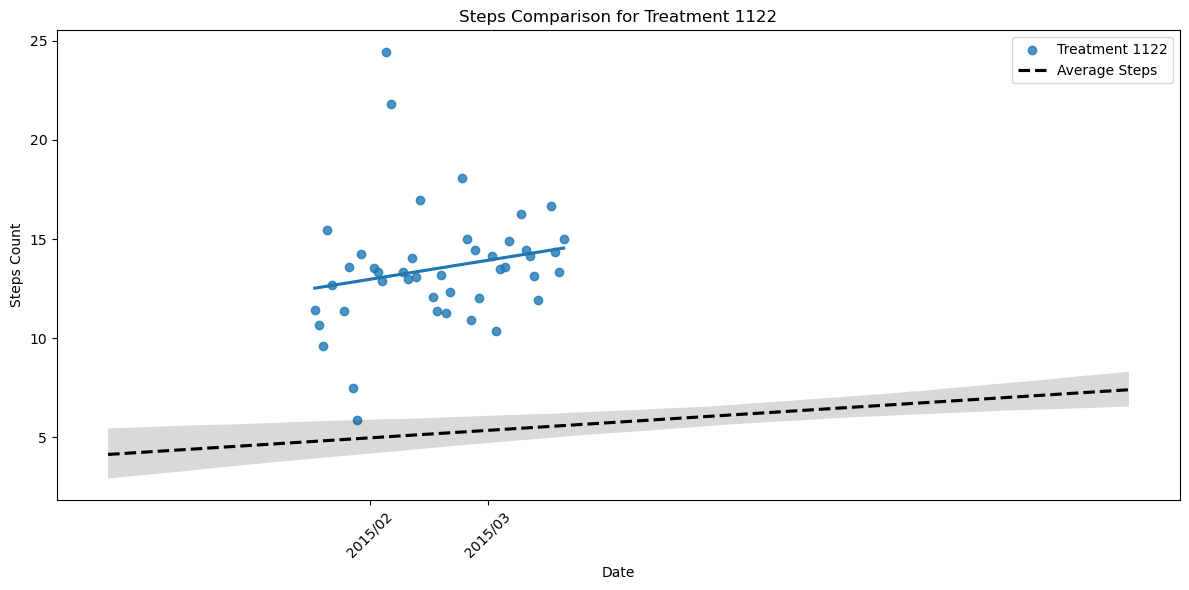

Plotting data for treatment 1123


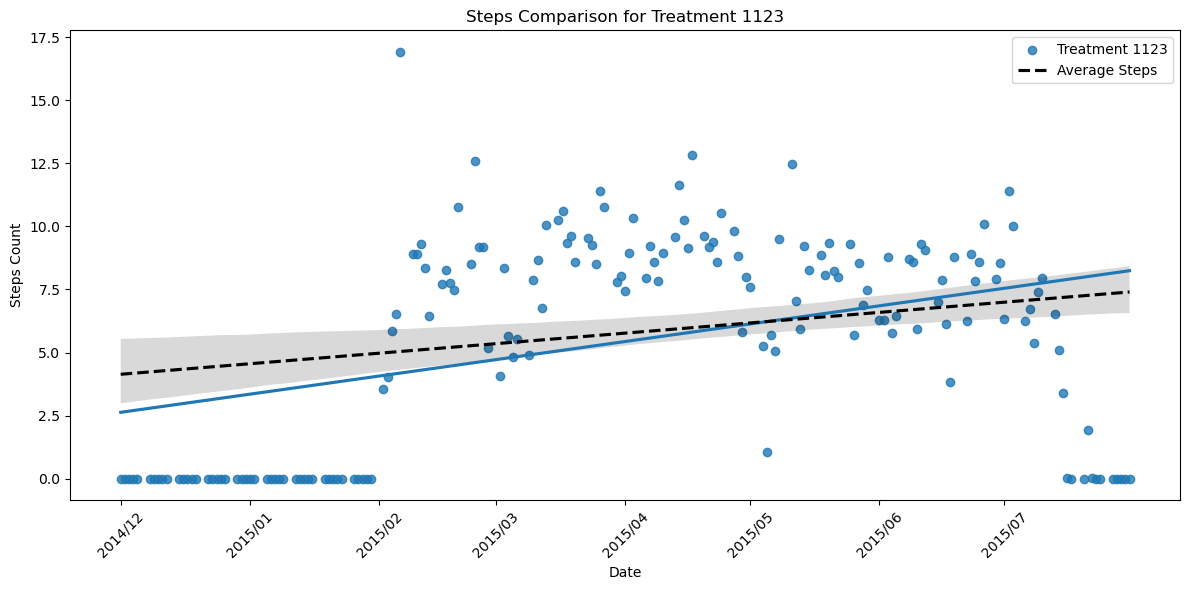

Plotting data for treatment 1124


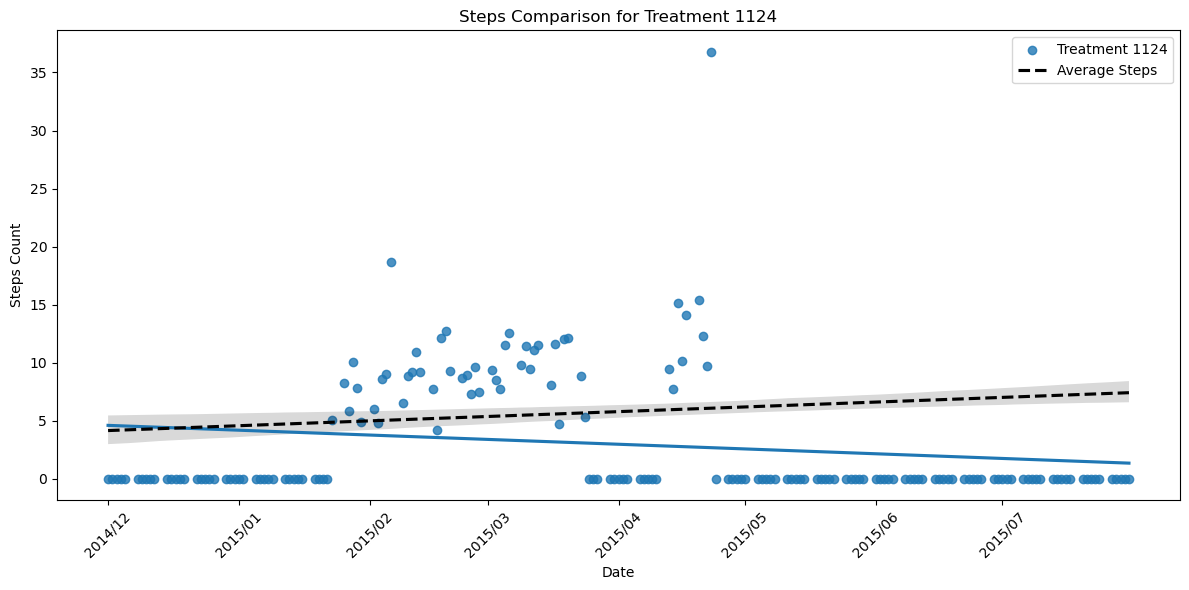

Plotting data for treatment 1125


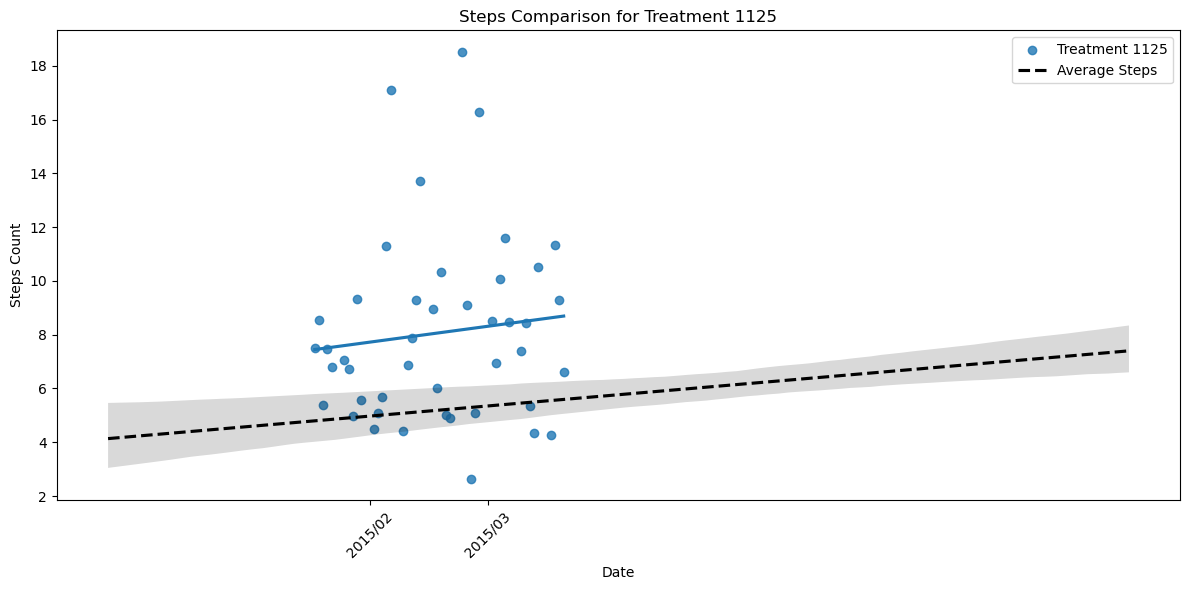

In [265]:
for treatment in treatment_ids:
    show_treatment_with_reference(
        individual_data=individual_means,
        average_data=average_steps,
        treatment_id=treatment,
        title_prefix="Steps Comparison",
        x_label="Date",
        y_label="Steps Count",
        rotate_xticks=45
    )

### Plot 7: Superposed individuals and average steps

In [266]:
# Define a list of colors manually (you peux ajouter plus si nécessaire)
treatment_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [267]:
# Make sure there are enough colors for the number of treatment IDs
if len(treatment_ids) > len(treatment_colors):
    raise ValueError("Not enough colors for the number of treatment IDs!")

In [268]:
def plot_treatments_with_average(individual_data, average_data, treatment_ids,
                                    treatment_colors=None, fig_size=(12, 6),
                                    title="Treatment Steps Comparison",
                                    x_label="Date", y_label="Average Steps",
                                    rotate_xticks=45):
    """
    Plot multiple treatments with scatter points, regression lines, and average reference.

    Parameters:
    -----------
    individual_data : pd.DataFrame
        DataFrame containing individual treatment data
    average_data : pd.DataFrame
        DataFrame containing average steps data
    treatment_ids : list
        List of treatment IDs to plot
    treatment_colors : list
        List of colors for each treatment (default uses seaborn palette)
    fig_size : tuple
        Figure size (width, height)
    title : str
        Plot title
    x_label : str
        Label for x-axis
    y_label : str
        Label for y-axis
    rotate_xticks : int
        Rotation angle for x-axis tick labels
    """
    # Set default colors if not provided
    if treatment_colors is None or len(treatment_colors) < len(treatment_ids):
        treatment_colors = sns.color_palette(n_colors=len(treatment_ids))

    # Prepare common elements
    min_date = average_data['date'].min()
    months = pd.date_range(start=min_date,
                            end=average_data['date'].max(),
                            freq='MS')
    month_numeric = (months - min_date).days

    # Create figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Plot each treatment
    for i, treatment in enumerate(treatment_ids):
        subset = individual_data[individual_data['treatment_id'] == treatment].copy()
        subset['date_numeric'] = (subset['date'] - min_date).dt.days

        # Plot scatter points
        sns.regplot(
            x=subset['date_numeric'],
            y=subset['steps'],
            scatter=True,
            ci=None,
            label=f'Treatment {treatment}',
            color=treatment_colors[i],
            scatter_kws={'alpha': 0.6},
            ax=ax
        )

        # Plot regression line
        sns.regplot(
            x=subset['date_numeric'],
            y=subset['steps'],
            scatter=False,
            ci=None,
            color=treatment_colors[i],
            line_kws={'alpha': 0.8},
            ax=ax
        )

    # Plot average reference line
    avg_data = average_data.copy()
    avg_data['date_numeric'] = (avg_data['date'] - min_date).dt.days
    sns.regplot(
        x=avg_data['date_numeric'],
        y=avg_data['steps'],
        scatter=False,
        ci=95,
        label='Average Steps',
        color='black',
        line_kws={'linestyle': '--', 'alpha': 0.8},
        ax=ax
    )

    # Configure plot appearance
    ax.set_xticks(month_numeric)
    ax.set_xticklabels(months.strftime('%Y/%m'), rotation=rotate_xticks)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()

    plt.tight_layout()
    plt.show()

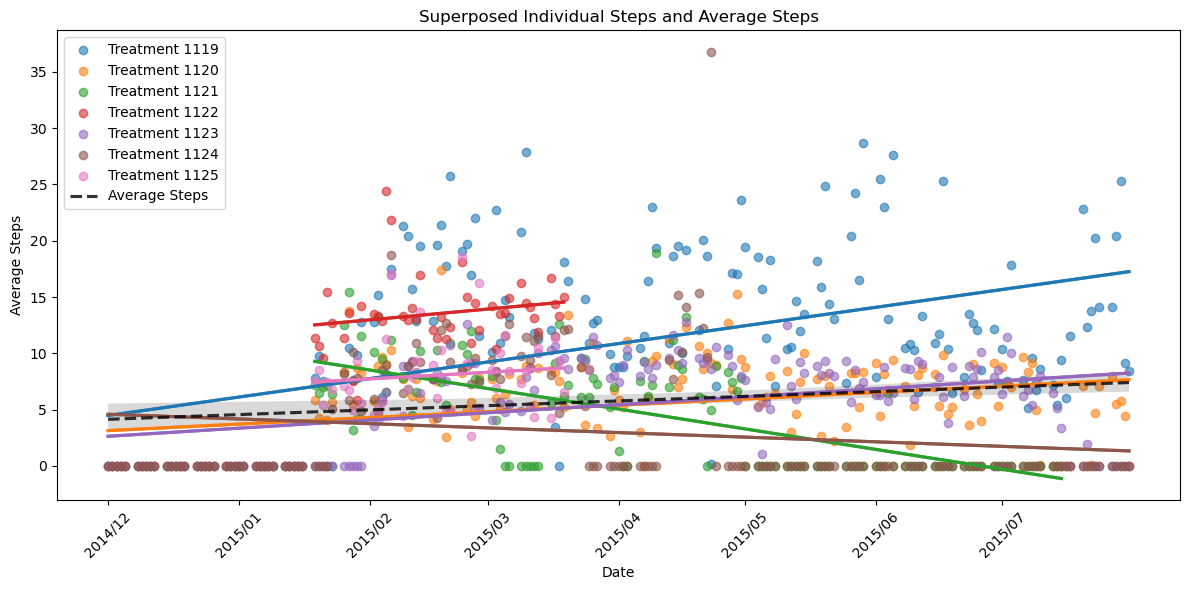

In [269]:
treatment_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Add more if needed
plot_treatments_with_average(
    individual_data=individual_means,
    average_data=average_steps,
    treatment_ids=treatment_ids,
    treatment_colors=treatment_colors,
    title="Superposed Individual Steps and Average Steps",
    x_label="Date",
    y_label="Average Steps",
    rotate_xticks=45
)

The analysis continues with several more visualizations:

1. Average Steps Calculation: Computes overall average steps per minute, hour, and day

2. User Comparison: Shows how each user compares to the overall average

3. Trend Analysis: Visualizes step trends across all treatment groups

4. Superposed Comparison: Overlays individual user trends with overall average

Key findings:

- Overall average is about 8306 steps per day
- Users 1122 and 1119 consistently exceed the average
- Users 1120, 1121, and 1124 are typically below average
- Activity patterns are relatively stable over time

### Plot 8: Hourly Activity Patterns

In [270]:
def plot_hourly_patterns(df, value_column='steps', fig_size=(14, 6),
                        title='Average Steps by Hour of Day',
                        x_label='Hour of Day', y_label='Average Steps',
                        legend_title='Treatment ID', grid=True):
    """
    Analyzes how activity varies by hour of day across users

    Parameters:
    - df: DataFrame containing the activity data
    - value_column: Metric to analyze (default: steps)
    - fig_size: Figure dimensions
    - title: Plot title
    - x_label: X-axis label
    - y_label: Y-axis label
    - legend_title: Legend title
    - grid: Whether to show grid lines
    """
    # Extract hour and calculate averages
    df = df.copy()
    df['hour'] = df['date'].dt.hour
    hourly_activity = df.groupby(['treatment_id', 'hour']).agg({
        'steps': 'mean'
    }).reset_index()

    # Create plot
    plt.figure(figsize=fig_size)
    ax = sns.lineplot(
        data=hourly_activity,
        x='hour',
        y=value_column,
        hue='treatment_id',
        errorbar=None,  # No confidence intervals
        palette='deep',  # Color scheme
        linewidth=2.5,   # Line thickness
        marker=None,      # No markers
        estimator=None    # Show actual values
    )

    # Formatting
    ax.set_title(title, pad=20, fontsize=14)
    ax.set_xlabel(x_label, labelpad=10)
    ax.set_ylabel(y_label, labelpad=10)
    ax.set_xticks(range(0, 18))  # Only up to 6 PM
    ax.set_xticklabels(range(0, 18))

    # Grid styling
    if grid:
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

    # Legend styling
    legend = ax.legend(
        title=legend_title,
        frameon=True,
        framealpha=1,
        edgecolor='black',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    legend.get_title().set_fontsize(12)

    plt.tight_layout()
    plt.show()

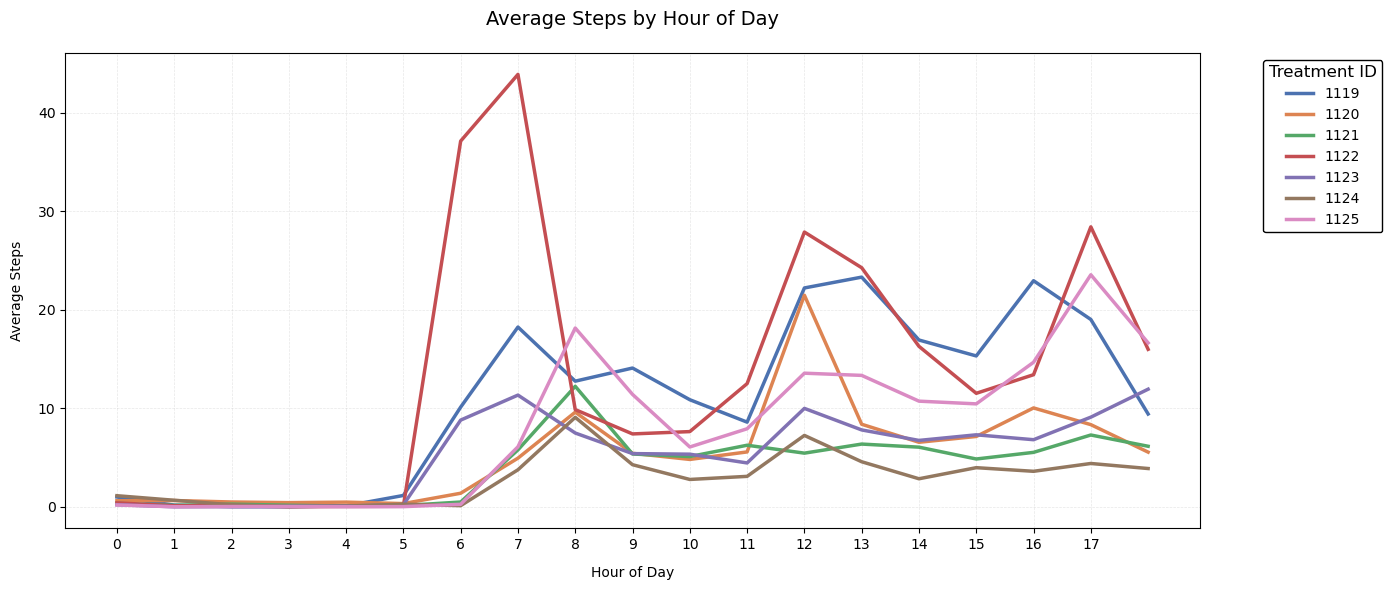

In [271]:
plot_hourly_patterns(df)

Hourly Pattern Insights:

- All users show similar diurnal patterns
- Lowest activity in early morning (12AM-6AM)
- Morning peak around 8-9AM
- Midday activity varies by user
- Afternoon activity typically lower than morning

### Plot 9: Weekly Activity Patterns

In [272]:
print("\nPLOT 9: Weekly Activity Patterns")


PLOT 9: Weekly Activity Patterns


In [273]:
def plot_weekly_patterns(df):
    """
    Analyzes how activity varies by day of week

    Parameters:
    - df: DataFrame containing the activity data
    """
    # Create day of week and hour features
    df['weekday'] = df['date'].dt.day_name()
    df['hour'] = df['date'].dt.hour

    # Define weekday order (Monday-Friday)
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    df['weekday'] = pd.Categorical(df['weekday'], categories=weekdays, ordered=True)

    # Create FacetGrid to show each weekday separately
    g = sns.FacetGrid(df, col='weekday', col_wrap=3,
                        height=4, aspect=1.2)

    # Plot hourly steps for each weekday
    g.map_dataframe(
        sns.lineplot,
        x='hour',
        y='steps',
        hue='treatment_id',
        estimator='mean',
        errorbar=None
    )

    g.add_legend()
    g.set_axis_labels("Hour of Day", "Average Steps")
    g.set_titles('{col_name}')

    plt.suptitle('Average Hourly Steps by Weekday', y=1.02)
    plt.show()

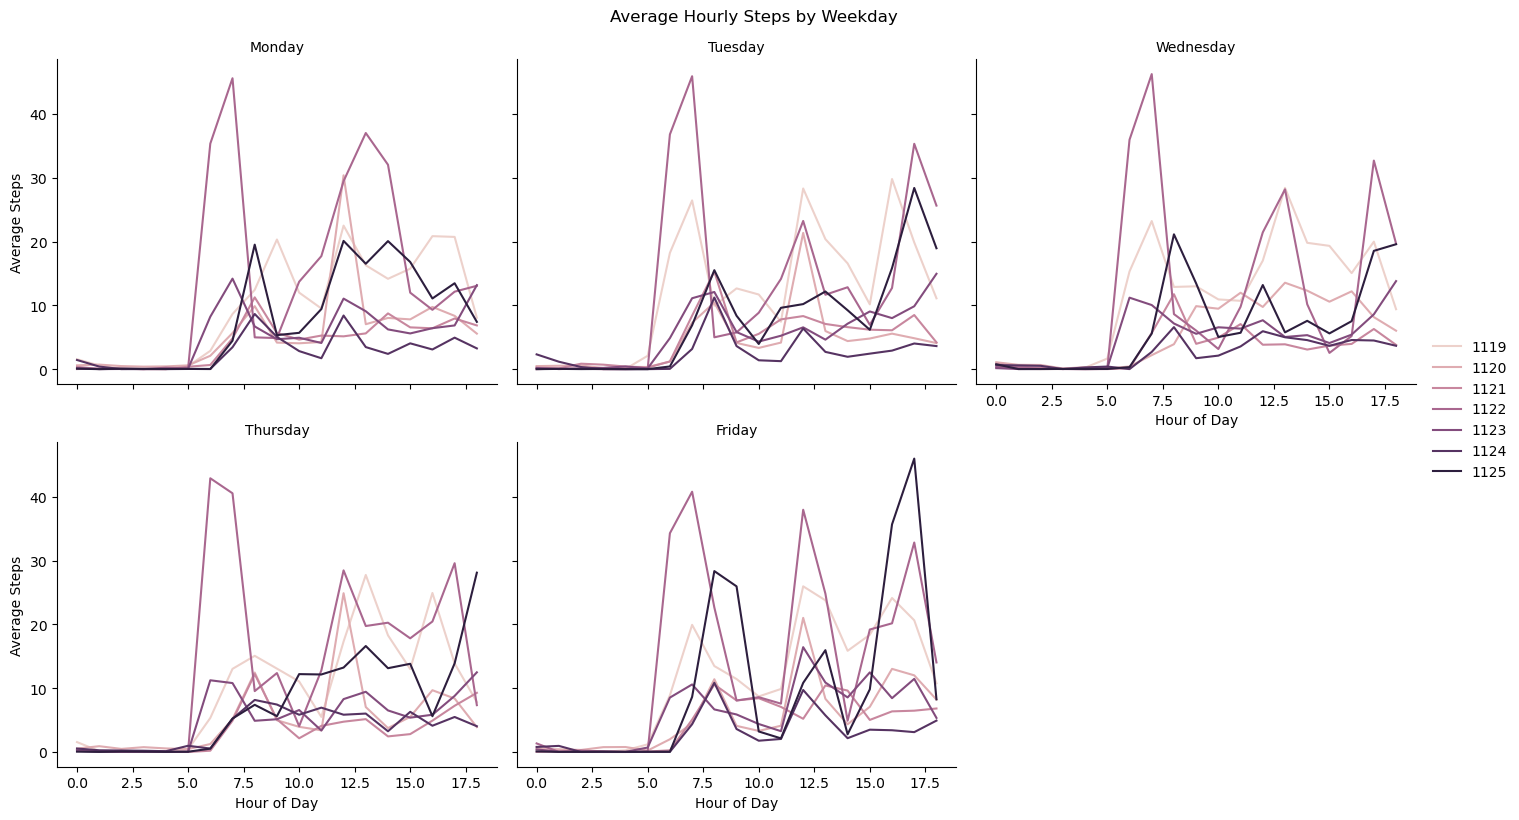

In [274]:
plot_weekly_patterns(df)

Weekly Pattern Insights:

- Activity patterns are consistent across weekdays
- No clear "weekend effect" (since weekends are excluded)
- Tuesday often shows slightly higher activity
- Friday afternoon activity sometimes declines

### Plot 10: Correlation Analysis

In [275]:
def plot_correlation_matrix(corr, fig_size=(10, 8), title="Correlation Matrix",
                            x_label="Features", y_label="Features",
                            cmap='coolwarm', center=0, annot=True,
                            font_size=20, fmt=".2f"):
    """
    Visualizes feature correlations as a heatmap

    Parameters:
    - corr: Correlation matrix DataFrame
    - fig_size: Figure dimensions
    - title: Plot title
    - x_label: X-axis label
    - y_label: Y-axis label
    - cmap: Color map
    - center: Value to center colormap
    - annot: Whether to show values
    - font_size: Font size
    - fmt: Number format
    """
    plt.figure(figsize=fig_size)
    ax = sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        center=center,
        fmt=fmt
    )

    ax.set_title(title, fontsize=font_size, pad=20)
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=font_size*0.5)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size*0.5)

    plt.tight_layout()
    plt.show()

In [276]:
# Calculate correlations
df_numeric = df.select_dtypes(include=['number'])
corr = df_numeric.corr()
corr = corr.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [277]:
# Filter low correlations
threshold = 0.1
mask = (corr.abs() < threshold).sum(axis=0) == (corr.shape[0] - 1)
low_correlation_cols = corr.columns[mask]
corr = corr.drop(columns=low_correlation_cols, index=low_correlation_cols)

In [278]:
print("Correlation Matrix:")
print(corr)

Correlation Matrix:
              treatment_id     fitbit_id  calories      mets     level  \
treatment_id  1.000000e+00  4.944617e-01 -0.080474 -0.074068 -0.057022   
fitbit_id     4.944617e-01  1.000000e+00 -0.114733 -0.074746 -0.069461   
calories     -8.047423e-02 -1.147326e-01  1.000000  0.979682  0.932630   
mets         -7.406770e-02 -7.474553e-02  0.979682  1.000000  0.956264   
level        -5.702217e-02 -6.946139e-02  0.932630  0.956264  1.000000   
steps        -7.646324e-02 -6.159998e-02  0.951678  0.964365  0.906122   
distance     -6.877689e-02 -6.164297e-02  0.953731  0.963526  0.903394   
hour          4.508018e-14  2.794588e-14  0.196908  0.206040  0.202056   

                 steps  distance          hour  
treatment_id -0.076463 -0.068777  4.508018e-14  
fitbit_id    -0.061600 -0.061643  2.794588e-14  
calories      0.951678  0.953731  1.969078e-01  
mets          0.964365  0.963526  2.060400e-01  
level         0.906122  0.903394  2.020564e-01  
steps         1.000

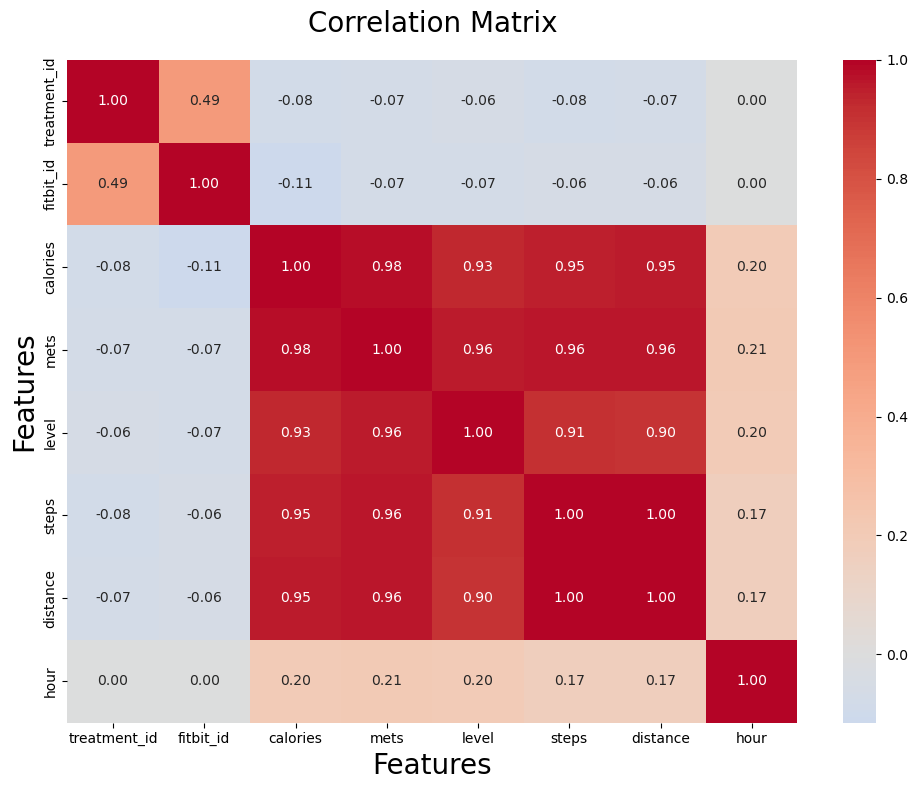

In [279]:
# Basic usage
plot_correlation_matrix(corr)

Correlation Insights:

- Strong positive correlations between:
    - Steps and distance (0.99)
    - Calories and METs (0.98)
    - Steps and calories (0.95)
- Moderate correlation with hour of day (0.17-0.21)
- Treatment ID and Fitbit ID show some correlation (0.49)

### Plot 11: Feature Relationships DAG

In [280]:
def plot_dag(dag, pos, fig_size=(10, 8), title="DAG Representing Feature Relationships",
                node_size=2000, node_color="skyblue", node_font_size=10,
                font_weight='bold', edge_color='black', title_font_size=20):
    """
    Visualizes feature relationships as a directed acyclic graph

    Parameters:
    - dag: NetworkX Directed Graph
    - pos: Node positions dictionary
    - fig_size: Figure dimensions
    - title: Plot title
    - node_size: Size of nodes
    - node_color: Node color
    - node_font_size: Label font size
    - font_weight: Label font weight
    - edge_color: Edge color
    - title_font_size: Title font size
    """
    plt.figure(figsize=fig_size)
    ax = plt.gca()

    nx.draw_networkx(
        dag,
        pos=pos,
        with_labels=True,
        node_size=node_size,
        node_color=node_color,
        font_size=node_font_size,
        font_weight=font_weight,
        edge_color=edge_color,
        ax=ax
    )

    ax.set_title(title, fontsize=title_font_size, pad=20)
    ax.axis('off')  # Turn off axis
    plt.tight_layout()
    plt.show()

In [281]:
# Create DAG structure
dag = nx.DiGraph()
dag_features = ['date', 'working_days', 'calories', 'mets', 'level', 'steps', 'distance', 'season']
dag.add_nodes_from(dag_features)

In [282]:
# Define relationships
edges = [
    ('date', 'working_days'),
    ('date', 'season'),
    ('working_days', 'steps'),
    ('season', 'steps'),
    ('steps', 'calories'),
    ('steps', 'mets'),
    ('steps', 'level'),
    ('steps', 'distance'),
]

In [283]:
dag.add_edges_from(edges)

In [284]:
# Define node positions
pos = {
    'date': (0, 1),
    'working_days': (-1, 0),
    'calories': (-1, -1),
    'mets': (0, -1),
    'season': (1, 0),
    'steps': (0, 0),
    'distance': (-1, -2),
    'level': (1, -2)
}

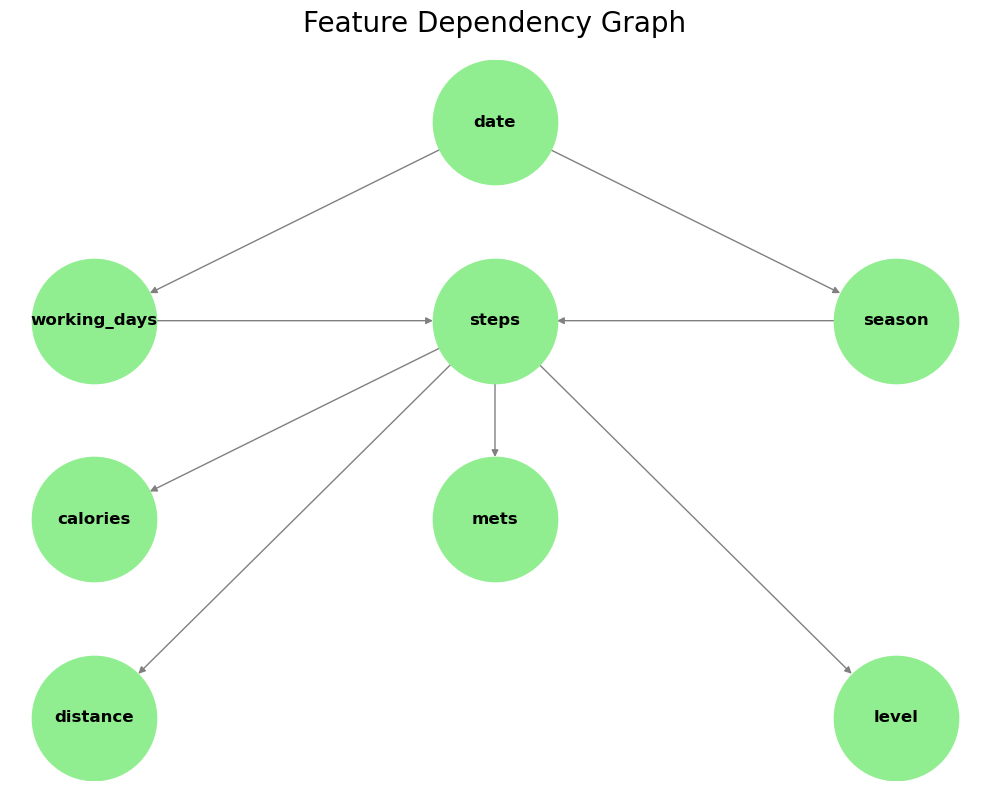

In [285]:
plot_dag(
    dag=dag,
    pos=pos,
    title="Feature Dependency Graph",
    node_color="lightgreen",
    node_size=8000,
    edge_color="gray",
    node_font_size=12
)

In [286]:
print("Exploratory data analysis complete!\n")

Exploratory data analysis complete!



DAG Insights:

- Shows the assumed causal relationships between features
-Date influences both season and working days
- Steps are central to the model, influencing multiple other metrics
- Helps understand which features might be redundant

## Step 4: Feature Engineering

In [287]:
print("STEP 4: Feature engineering...")

STEP 4: Feature engineering...


In [288]:
def get_season(date):
    """Determine season from date"""
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [289]:
print("Adding temporal features...")

# Create multiple time-based features
df['season'] = df['date'].apply(get_season)  # Categorical season
df['hour'] = df['date'].dt.hour  # Hour of day
df['is_weekend'] = df['date'].dt.weekday >= 5  # Weekend flag
df['cumulative_steps'] = df.groupby(['treatment_id', df['date'].dt.date])['steps'].cumsum()  # Running total
df['day_of_year'] = df['date'].dt.dayofyear  # Day number
df['week_of_year'] = df['date'].dt.isocalendar().week  # Week number
df['month'] = df['date'].dt.month  # Month number

Adding temporal features...


In [290]:
print("Creating target variable...")

# Create binary target (1 = reached step goal, 0 = didn't reach)
df['target'] = 0
for user_id, user_avg in df[df['date'].dt.hour <= 18].groupby('treatment_id')['cumulative_steps'].mean().items():
    mask = (df['treatment_id'] == user_id) & (df['date'].dt.hour <= 18)
    df.loc[mask, 'target'] = (df.loc[mask, 'cumulative_steps'] >= user_avg).astype(int)

Creating target variable...


In [291]:
print("Creating one-hot encoded features...")

# Convert season to dummy variables
for season in ['Spring', 'Summer', 'Autumn', 'Winter']:
    df[f'season_{season}'] = (df['season'] == season).astype(int)

Creating one-hot encoded features...


In [292]:
print("Adding derived features...")

# Create additional predictive features
df['steps_per_hour'] = df['cumulative_steps'] / (df['hour'] + 1)
df['steps_remaining'] = (overall_avg_steps * 60 * 24) - df['cumulative_steps']
df['hours_remaining'] = 18 - df['hour']
df['required_pace'] = df['steps_remaining'] / (df['hours_remaining'] + 0.1)

Adding derived features...


In [293]:
# Final feature set
features = [
    'hour', 'is_weekend', 'cumulative_steps', 'steps_per_hour',
    'steps_remaining', 'hours_remaining', 'required_pace',
    'season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter',
    'month'
]

In [294]:
print("Final feature set:")
print(features)

Final feature set:
['hour', 'is_weekend', 'cumulative_steps', 'steps_per_hour', 'steps_remaining', 'hours_remaining', 'required_pace', 'season_Spring', 'season_Summer', 'season_Autumn', 'season_Winter', 'month']


In [295]:
print("Cleaning data...")

# Remove rows with missing values
df_clean = df.dropna(subset=features).copy()
print(f"Clean dataset shape: {df_clean.shape}")

Cleaning data...
Clean dataset shape: (1043100, 25)


In [296]:
print("Feature engineering complete!\n")

Feature engineering complete!



Feature Engineering Details:

1. Temporal Features:

    - Season, hour, weekend flag
    - Day of year, week of year, month

2. Target Variable:

    - Binary indicator of whether user reached their average step goal
    - Calculated per-user based on their historical average

3. Derived Features:

    - Cumulative steps
    - Steps per hour
    - Steps remaining to reach goal
    - Hours remaining in day
    - Required pace to reach goal

4. One-Hot Encoding:

    - Converted season to binary indicators

5. Data Cleaning:

    - Removed rows with missing values
    - Final clean dataset has 1,043,100 rows

## Step 5: Model Training and Evaluation

In [297]:
print("STEP 5: Model training and evaluation...")

STEP 5: Model training and evaluation...


In [298]:
# Define label mapping for interpretability
label_map = {0: "Not Reached", 1: "Reached"}

In [299]:
print("Splitting data into train and test sets...")

# Split by user ID to avoid data leakage
train_users, test_users = train_test_split(df_clean['treatment_id'].unique(), test_size=0.3, random_state=42)
train_data = df_clean[df_clean['treatment_id'].isin(train_users)]
test_data = df_clean[df_clean['treatment_id'].isin(test_users)]

Splitting data into train and test sets...


In [300]:
print("\nUser IDs for training:", train_users)
print("User IDs for testing:", test_users)


User IDs for training: [1121 1123 1122 1125]
User IDs for testing: [1119 1120 1124]


In [301]:
# Prepare feature matrices and target vectors
X_train = train_data[features]
y_train = train_data['target']
X_test = test_data[features]
y_test = test_data['target']

In [302]:
# Show class distribution
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True).rename(label_map))

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True).rename(label_map))


Class distribution in training set:
target
Not Reached    0.649993
Reached        0.350007
Name: proportion, dtype: float64

Class distribution in test set:
target
Not Reached    0.71801
Reached        0.28199
Name: proportion, dtype: float64


In [303]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, label_map=None, apply_smote=True):
    """
    Train and evaluate a Random Forest classifier with optional SMOTE balancing.

    Parameters:
    -----------
    X_train : pd.DataFrame or np.array
        Training features
    y_train : pd.Series or np.array
        Training labels
    X_test : pd.DataFrame or np.array
        Test features
    y_test : pd.Series or np.array
        Test labels
    label_map : dict, optional
        Mapping dictionary for label conversion
    apply_smote : bool, optional
        Whether to apply SMOTE oversampling, defaults to True

    Returns:
    --------
    tuple
        (trained_model, classification_report_dict, y_test_mapped, y_pred_mapped, y_pred)
    """
    # Enable metadata routing if available
    if hasattr(set_config, 'enable_metadata_routing'):
        set_config(enable_metadata_routing=True)

    default_params = {
        'random_state': 42,
        'class_weight': 'balanced',
        'n_estimators': 200,
        'min_samples_leaf': 5,
        'max_depth': 10,
        'verbose': 1  # Enable built-in verbose output
    }

    try:
        if apply_smote:
            smote = SMOTE(random_state=42)
            print("\nApplying SMOTE for class balancing...")
            with tqdm(total=1, desc="SMOTE Progress") as pbar:
                X_res, y_res = smote.fit_resample(X_train, y_train)
                pbar.update(1)
            print("SMOTE resampling completed.")
        else:
            X_res, y_res = X_train, y_train
            print("Using original imbalanced data")

        print("\nTraining Random Forest model...")
        model = RandomForestClassifier(**default_params)

        # Create progress bar for tree building
        pbar = tqdm(total=default_params['n_estimators'], desc="Building Trees")

        # For sklearn versions that support callbacks
        if hasattr(model, 'set_fit_request'):
            try:
                def update_pbar(*args, **kwargs):
                    pbar.update(1)
                model.set_fit_request(callback=update_pbar)
                model.fit(X_res, y_res)
            except RuntimeError:
                # Fallback if metadata routing not enabled
                model.fit(X_res, y_res)
                pbar.update(default_params['n_estimators'])
        else:
            # For older sklearn versions
            model.fit(X_res, y_res)
            pbar.update(default_params['n_estimators'])

        pbar.close()
        y_pred = model.predict(X_test)

        # Map labels if provided
        y_test_mapped = y_test.map(label_map) if label_map else y_test
        y_pred_mapped = pd.Series(y_pred).map(label_map) if label_map else y_pred

        report = classification_report(y_test_mapped, y_pred_mapped, output_dict=True)
        report.pop("accuracy", None)

        print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.2f}")
        print("\nClassification Report:")
        print(classification_report(y_test_mapped, y_pred_mapped))

        return model, report, y_test_mapped, y_pred_mapped, y_pred

    except ValueError as e:
        print(f"\nSMOTE Error: {e}")
        print("Falling back to original imbalanced data")
        model = RandomForestClassifier(**default_params)

        # Progress bar for fallback training
        with tqdm(total=default_params['n_estimators'], desc="Building Trees (Fallback)") as pbar:
            model.fit(X_train, y_train)
            pbar.update(default_params['n_estimators'])

        return model, None, None, None

In [304]:
def show_classification_heatmap(report, fig_size=(12, 6), cmap='RdYlGn', title='Classification Report Heatmap'):
    """
    Display classification metrics as a heatmap.

    Parameters:
    -----------
    report : dict
        Classification report dictionary
    fig_size : tuple, optional
        Figure dimensions, defaults to (12, 6)
    cmap : str, optional
        Colormap for heatmap, defaults to 'RdYlGn'
    title : str, optional
        Plot title, defaults to 'Classification Report Heatmap'
    """
    plt.figure(figsize=fig_size)
    sns.heatmap(
        pd.DataFrame(report).iloc[:-1, :].T,
        annot=True,
        cmap=cmap,
        vmin=0,
        vmax=1,
        cbar=True
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [305]:
def show_classification_metrics(report, fig_size=(12, 6),
                                palette={'precision': 'blue', 'recall': 'orange', 'f1-score': 'green'},
                                title='Classification Report Metrics'):
    """
    Display classification metrics as a bar plot.

    Parameters:
    -----------
    report : dict
        Classification report dictionary
    fig_size : tuple, optional
        Figure dimensions, defaults to (12, 6)
    palette : dict, optional
        Color palette for metrics, defaults to blue/orange/green
    title : str, optional
        Plot title, defaults to 'Classification Report Metrics'
    """
    metrics_df = pd.DataFrame(report).transpose().iloc[:-1, :]
    metrics_df = metrics_df.reset_index().melt(
        id_vars='index',
        value_vars=['precision', 'recall', 'f1-score'],
        var_name='Metric',
        value_name='Score'
    )

    plt.figure(figsize=fig_size)
    sns.barplot(
        x='index',
        y='Score',
        hue='Metric',
        data=metrics_df,
        palette=palette
    )
    plt.title(title)
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [306]:
print("\nTraining model with SMOTE...")
# Train Random Forest with SMOTE for class imbalance
model, report, y_test_mapped, y_pred_mapped, y_pred = train_and_evaluate_model(
    X_train, y_train, X_test, y_test,
    label_map=label_map,
    apply_smote=True
)


Training model with SMOTE...

Applying SMOTE for class balancing...


SMOTE Progress:   0%|          | 0/1 [00:00<?, ?it/s]

SMOTE resampling completed.

Training Random Forest model...


Building Trees:   0%|          | 0/200 [00:00<?, ?it/s]

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   43.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.7s



Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

 Not Reached       0.99      0.97      0.98    429729
     Reached       0.92      0.97      0.95    168771

    accuracy                           0.97    598500
   macro avg       0.96      0.97      0.96    598500
weighted avg       0.97      0.97      0.97    598500



In [307]:
def calculate_all_metrics(y_true, y_pred):
    """
    Calculate, print, and return comprehensive classification metrics including
    accuracy, F1 score, sensitivity (recall), specificity, and precision.

    Handles both binary and multiclass classification scenarios automatically.

    Parameters:
    -----------
    y_true : array-like
        Ground truth (correct) target values
    y_pred : array-like
        Estimated targets as returned by a classifier

    Returns:
    --------
    dict
        Dictionary containing all computed metrics with keys:
        - 'accuracy': overall accuracy score
        - 'f1_score': weighted F1 score
        - 'sensitivity': list of sensitivities per class (multiclass) or single value (binary)
        - 'specificity': list of specificities per class (multiclass) or single value (binary)
        - 'confusion_matrix': computed confusion matrix
    """
    # Calculate basic metrics (weighted averages for multiclass)
    accuracy = accuracy_score(y_true, y_pred)  # Overall correctness
    f1 = f1_score(y_true, y_pred, average='weighted')  # Harmonic mean of precision/recall
    recall = recall_score(y_true, y_pred, average='weighted')  # Same as sensitivity
    precision = precision_score(y_true, y_pred, average='weighted')  # Positive predictive value

    # Compute confusion matrix - fundamental for specificity/sensitivity calculations
    cm = confusion_matrix(y_true, y_pred)

    # Binary classification case (2x2 confusion matrix)
    if len(cm) == 2:
        # Unpack confusion matrix values
        tn, fp, fn, tp = cm.ravel()  # True negatives, false positives, false negatives, true positives

        # Specificity = True Negative Rate = TN / (TN + FP)
        specificity = tn / (tn + fp)

        # Sensitivity = Recall = True Positive Rate = TP / (TP + FN)
        sensitivity = tp / (tp + fn)

        # Print formatted metrics
        print(f"\nBinary Classification Metrics:")
        print(f"Accuracy: {accuracy:.4f}")  # Overall accuracy
        print(f"F1 Score: {f1:.4f}")  # Balance between precision and recall
        print(f"Sensitivity (Recall): {sensitivity:.4f}")  # True positive rate
        print(f"Specificity: {specificity:.4f}")  # True negative rate
        print(f"Precision: {precision:.4f}")  # Positive predictive value

    # Multiclass classification case (NxN confusion matrix)
    else:
        # Initialize lists to store per-class metrics
        specificity = []  # True Negative Rate for each class
        sensitivity = []  # True Positive Rate for each class

        # Calculate metrics for each class
        for i in range(len(cm)):
            # True negatives: all correctly predicted non-class samples
            tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])

            # False positives: predicted as class i but actually not
            fp = cm[:,i].sum() - cm[i,i]

            # False negatives: actually class i but predicted otherwise
            fn = cm[i,:].sum() - cm[i,i]

            # True positives: correctly predicted as class i
            tp = cm[i,i]

            # Calculate and store class-specific metrics
            specificity.append(tn / (tn + fp))  # Class-specific specificity
            sensitivity.append(tp / (tp + fn))  # Class-specific sensitivity

        # Print multiclass summary metrics (weighted averages)
        print(f"\nMulticlass Classification Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score (weighted): {f1:.4f}")
        print(f"Sensitivity/Recall (weighted): {recall:.4f}")
        print(f"Precision (weighted): {precision:.4f}")

        # Print per-class metrics
        print("\nClass-specific Metrics:")
        for i, (spec, sens) in enumerate(zip(specificity, sensitivity)):
            print(f"Class {i}: Specificity={spec:.4f}, Sensitivity={sens:.4f}")

    # Return all metrics in a structured dictionary
    return {
        'accuracy': accuracy,  # Overall accuracy score
        'f1_score': f1,  # Weighted F1 score
        'sensitivity': sensitivity if len(cm) > 2 else sensitivity,  # List or single value
        'specificity': specificity if len(cm) > 2 else specificity,  # List or single value
        'confusion_matrix': cm  # Full confusion matrix
    }

In [308]:
# Calculate and display all metrics
metrics = calculate_all_metrics(y_test_mapped, y_pred_mapped)


Binary Classification Metrics:
Accuracy: 0.9694
F1 Score: 0.9697
Sensitivity (Recall): 0.9733
Specificity: 0.9680
Precision: 0.9705


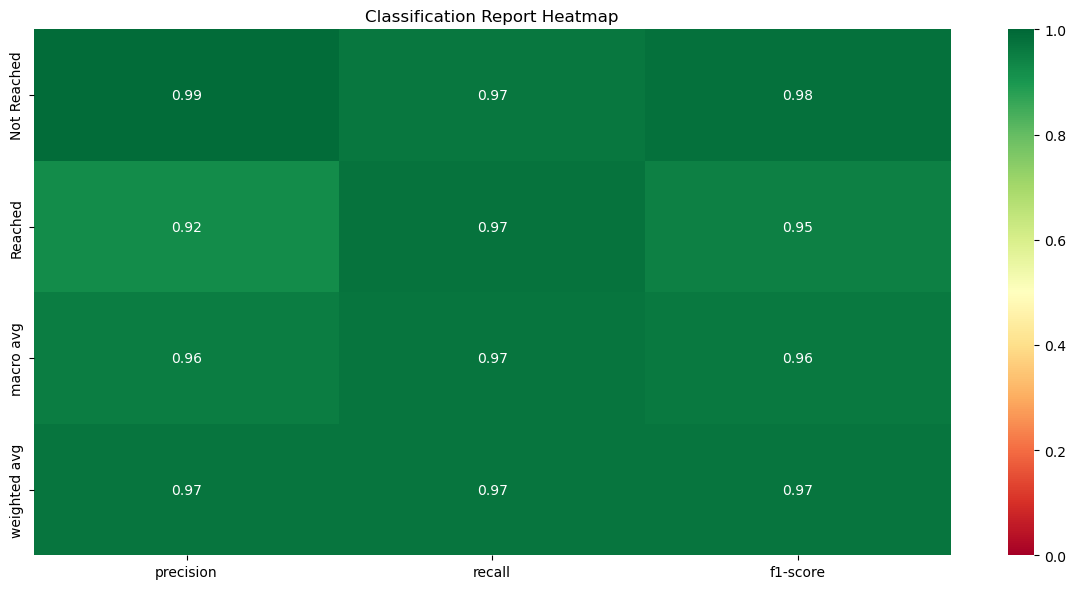

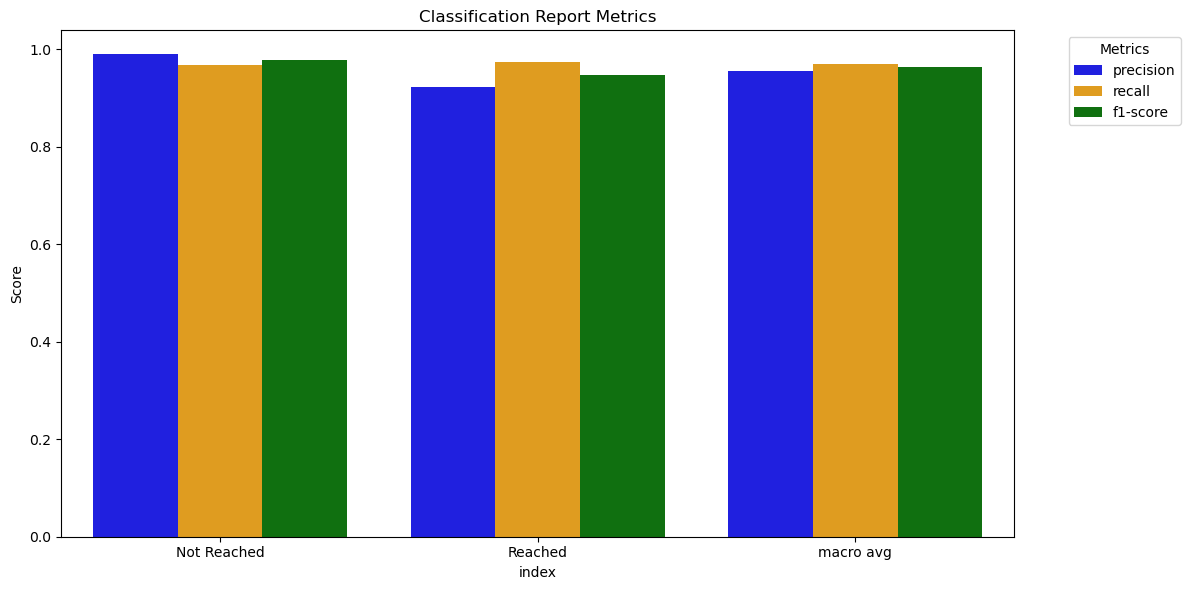

In [309]:
# Show evaluation visualizations
if report:
    show_classification_heatmap(report)
    show_classification_metrics(report)

In [310]:
# Confusion matrix analysis
cm = confusion_matrix(y_test, y_pred)

print("\n" + "="*50)
print("DETAILED CONFUSION MATRIX ANALYSIS")
print("="*50)
print(f"True Negatives (Correct {label_map[0]}): {cm[0,0]}")
print(f"False Positives ({label_map[0]} predicted as {label_map[1]}): {cm[0,1]}")
print(f"False Negatives ({label_map[1]} predicted as {label_map[0]}): {cm[1,0]}")
print(f"True Positives (Correct {label_map[1]}): {cm[1,1]}")
print("\nSummary:")
print(f"Total errors: {cm[0,1] + cm[1,0]} ({(cm[0,1] + cm[1,0])/cm.sum()*100:.2f}% of cases)")
print("="*50 + "\n")


DETAILED CONFUSION MATRIX ANALYSIS
True Negatives (Correct Not Reached): 415957
False Positives (Not Reached predicted as Reached): 13772
False Negatives (Reached predicted as Not Reached): 4513
True Positives (Correct Reached): 164258

Summary:
Total errors: 18285 (3.06% of cases)



In [311]:
print("\n" + "="*50)
print("COMPLETE CLASSIFICATION REPORT (Mapped Labels)")
print("="*50)

# Define target names using label_map
target_names = [label_map[0], label_map[1]]  # ["Not Reached", "Reached"]

# Generate and print classification report
report_str = classification_report(
    y_test,
    y_pred,
    target_names=target_names,
    digits=3
)
# Clean and print report (remove accuracy and empty lines)
print('\n'.join([
    line for line in report_str.split('\n')
    if 'accuracy' not in line and line.strip()
]))

# Calculate extended metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None
)

# Print formatted metrics with labels
print("\n" + "-"*40)
print("DETAILED PERFORMANCE METRICS")
print("-"*40)
print(f"{'Metric':<12} | {label_map[0]:<12} | {label_map[1]:<12}")
print("-"*40)
print(f"{'Precision':<12} | {precision[0]:<12.3f} | {precision[1]:<12.3f}")
print(f"{'Recall':<12} | {recall[0]:<12.3f} | {recall[1]:<12.3f}")
print(f"{'F1-Score':<12} | {f1[0]:<12.3f} | {f1[1]:<12.3f}")
print(f"{'Support':<12} | {support[0]:<12,.0f} | {support[1]:<12,.0f}")
print("="*50)


COMPLETE CLASSIFICATION REPORT (Mapped Labels)
              precision    recall  f1-score   support
 Not Reached      0.989     0.968     0.978    429729
     Reached      0.923     0.973     0.947    168771
   macro avg      0.956     0.971     0.963    598500
weighted avg      0.970     0.969     0.970    598500

----------------------------------------
DETAILED PERFORMANCE METRICS
----------------------------------------
Metric       | Not Reached  | Reached     
----------------------------------------
Precision    | 0.989        | 0.923       
Recall       | 0.968        | 0.973       
F1-Score     | 0.978        | 0.947       
Support      | 429,729      | 168,771     


In [312]:
def show_normalized_confusion_matrix(cm, label_map, model_name="Random Forest",
                                    fig_size=(10, 7), cmap='Blues',
                                    font_size=12, title_font_size=14):
    """
    Display a normalized confusion matrix as a percentage heatmap.

    Parameters:
    -----------
    cm : np.array
        Confusion matrix (2x2)
    label_map : dict
        Mapping from class indices to label names (e.g., {0: "Negative", 1: "Positive"})
    model_name : str, optional
        Name of model to include in title, defaults to "Random Forest"
    fig_size : tuple, optional
        Figure dimensions, defaults to (10, 7)
    cmap : str, optional
        Colormap for heatmap, defaults to 'Blues'
    font_size : int, optional
        Font size for annotations, defaults to 12
    title_font_size : int, optional
        Font size for title, defaults to 14

    Returns:
    --------
    None
        Displays the matplotlib plot
    """
    # Calculate normalized matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    annot_labels = np.array([f"{val:.1f}%" for val in cm_normalized.flatten()]).reshape(cm_normalized.shape)

    # Get label names
    labels = [label_map[0], label_map[1]]

    # Create plot
    plt.figure(figsize=fig_size)
    ax = sns.heatmap(
        cm_normalized,
        annot=annot_labels,
        fmt='',
        cmap=cmap,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=0.5,
        linecolor='grey',
        cbar_kws={'label': 'Percentage by Actual Class'},
        annot_kws={'size': font_size}
    )

    # Configure plot appearance
    ax.set_title(f'Normalized Confusion Matrix (%)\nModel: {model_name}',
                fontsize=title_font_size, pad=20)
    ax.set_xlabel('Model Predictions')
    ax.set_ylabel('True Values')

    # Set custom ticks to center labels
    ax.set_xticks([0.5, 1.5])
    ax.set_yticks([0.5, 1.5])
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels, rotation=0)

    plt.tight_layout()
    plt.show()

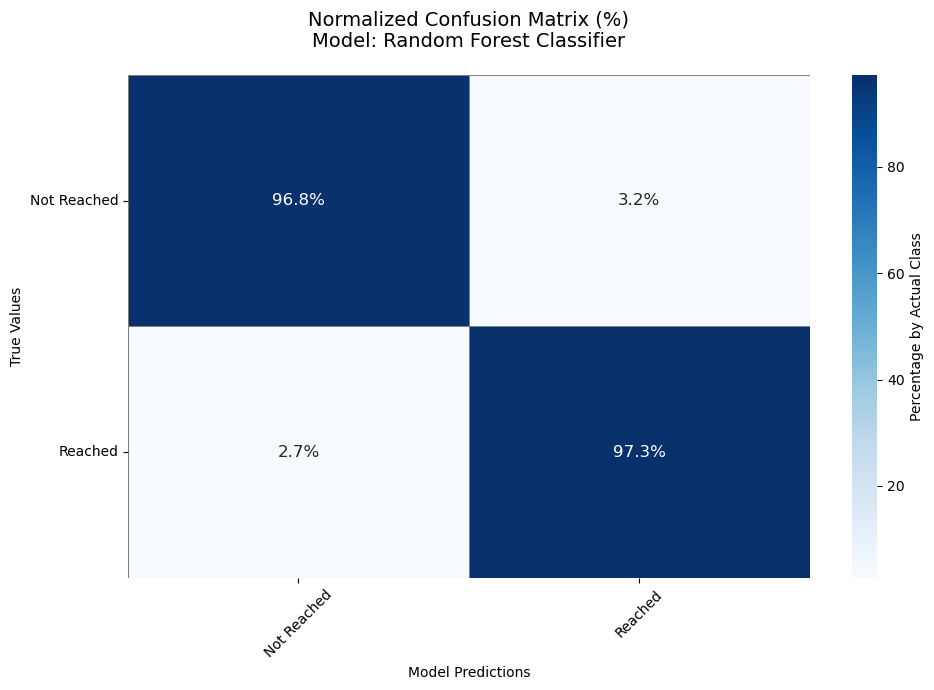

In [313]:
show_normalized_confusion_matrix(
    cm=cm,
    label_map=label_map,
    model_name="Random Forest Classifier",
    cmap='Blues',
    font_size=12,
    title_font_size=14
)

In [314]:
def plot_precision_recall_vs_threshold(y_true, y_probs, figsize=(8, 6)):
    """
    Plot precision and recall curves as a function of the decision threshold.

    Parameters:
    -----------
    y_true : array-like
        True binary labels (0 or 1)
    y_probs : array-like
        Predicted probabilities for the positive class (1)
    figsize : tuple, optional
        Size of the figure (width, height) in inches (default: (8, 6))
    """
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_true, y_probs)

    plt.figure(figsize=figsize)
    plt.plot(thresholds, precision_curve[:-1], label="Precision", linewidth=2, color='blue')
    plt.plot(thresholds, recall_curve[:-1], label="Recall", linewidth=2, color='orange')

    # Enhanced labels and titles
    plt.xlabel("Decision Threshold", fontsize=12, labelpad=10)
    plt.ylabel("Score", fontsize=12, labelpad=10)
    plt.legend(fontsize=11, framealpha=0.9)
    plt.title("Precision-Recall Tradeoff by Threshold", pad=20, fontsize=14, fontweight='bold')

    # Formatting improvements
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xlim([0, 1])  # Explicit threshold range
    plt.ylim([0, 1.05])  # Slight padding for visibility

    plt.tight_layout()
    plt.show()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.9s


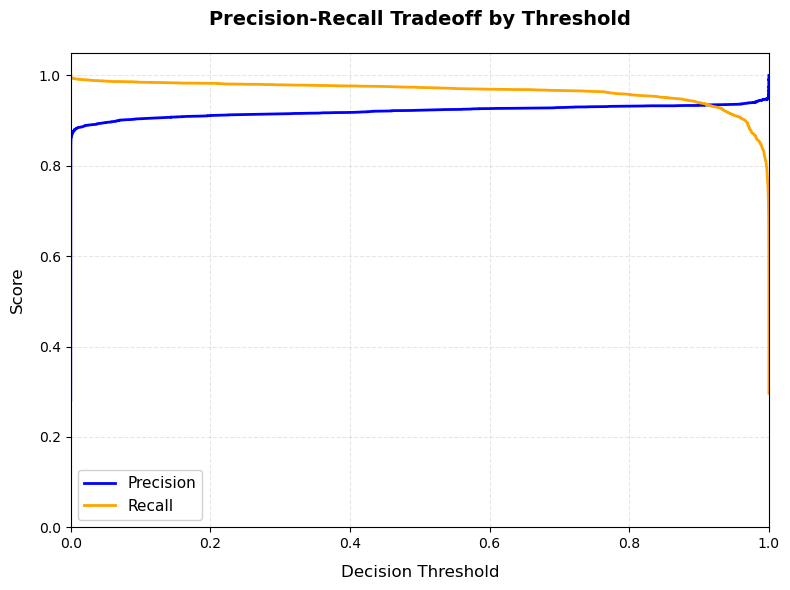

In [315]:
if hasattr(model, "predict_proba"):
    y_probs = model.predict_proba(X_test)[:, 1]
    plot_precision_recall_vs_threshold(y_test, y_probs)

In [316]:
def setup_error_data(y_test, y_pred, X_test):
    """
    Analyzes and characterizes the model's prediction errors by comparing false positives and false negatives.

    This function identifies misclassified instances (both false positives and false negatives) and calculates
    the average feature values for each error type. The comparison helps identify which features are most
    associated with different types of errors, providing insights for model improvement.

    Parameters:
    -----------
    y_test : array-like
        Ground truth (correct) target values. Should be a 1D array of binary labels (0 or 1).

    y_pred : array-like
        Estimated targets as returned by a classifier. Should be same shape as y_test.

    X_test : pandas.DataFrame or array-like
        Test features that were used to generate y_pred. If a DataFrame, will calculate feature means.

    Returns:
    --------
    dict
        A dictionary containing detailed error analysis with the following keys:

        - 'fp_indices': numpy.ndarray
            Indices of false positive cases (where model predicted 1 but true label was 0)

        - 'fn_indices': numpy.ndarray
            Indices of false negative cases (where model predicted 0 but true label was 1)

        - 'fp_means': pandas.Series or None
            Mean feature values for false positives (only if X_test is a DataFrame)

        - 'fn_means': pandas.Series or None
            Mean feature values for false negatives (only if X_test is a DataFrame)

        - 'comparison_df': pandas.DataFrame or None
            DataFrame comparing mean feature values between error types, with columns:
            'False Positives', 'False Negatives', and 'Difference' (FP - FN)
            Sorted by 'False Positives' in descending order
    """
    # Identify error cases using numpy array operations
    fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]  # False positives
    fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]  # False negatives

    # Calculate mean feature values for errors if input is pandas DataFrame
    if hasattr(X_test, 'iloc'):  # Check for pandas DataFrame
        fp_means = X_test.iloc[fp_indices].mean()
        fn_means = X_test.iloc[fn_indices].mean()

        # Create comparison DataFrame with difference column
        comparison_df = pd.DataFrame({
            'False Positives': fp_means,
            'False Negatives': fn_means
        }).sort_values(by='False Positives', ascending=False)
        comparison_df['Difference'] = comparison_df['False Positives'] - comparison_df['False Negatives']
    else:
        fp_means, fn_means, comparison_df = None, None, None

    return {
        'fp_indices': fp_indices,
        'fn_indices': fn_indices,
        'fp_means': fp_means,
        'fn_means': fn_means,
        'comparison_df': comparison_df
    }

In [317]:
error_data = setup_error_data(y_test, y_pred, X_test)

In [318]:
def print_error_summary(fp_indices, fn_indices, y_test):
    """Print basic error statistics"""
    print("\n" + "="*50)
    print("ERROR ANALYSIS")
    print("="*50)
    print(f"False positives (FP): {len(fp_indices)} cases ({len(fp_indices)/len(y_test)*100:.1f}%)")
    print(f"False negatives (FN): {len(fn_indices)} cases ({len(fn_indices)/len(y_test)*100:.1f}%)")

In [319]:
print_error_summary(error_data['fp_indices'], error_data['fn_indices'], y_test)


ERROR ANALYSIS
False positives (FP): 13772 cases (2.3%)
False negatives (FN): 4513 cases (0.8%)


In [320]:
def print_detailed_error_analysis(fp_means, fn_means, fp_indices, fn_indices, y_test):
    """Print detailed error characteristics"""
    print("\n" + "="*50)
    print("DETAILED ERROR ANALYSIS")
    print("="*50)

    print("\nAverage characteristics of False Positives (FP):")
    print(fp_means.to_frame().T.round(2))
    print(f"\nCount: {len(fp_indices)} cases ({len(fp_indices)/len(y_test)*100:.1f}% of total)")

    print("\nAverage characteristics of False Negatives (FN):")
    print(fn_means.to_frame().T.round(2))
    print(f"\nCount: {len(fn_indices)} cases ({len(fn_indices)/len(y_test)*100:.1f}% of total)")

In [321]:
print_detailed_error_analysis(error_data['fp_means'], error_data['fn_means'],
                                error_data['fp_indices'], error_data['fn_indices'], y_test)


DETAILED ERROR ANALYSIS

Average characteristics of False Positives (FP):
    hour  is_weekend  cumulative_steps  steps_per_hour  steps_remaining  \
0  10.54         0.0            2916.8          264.31          5389.79   

   hours_remaining  required_pace  season_Spring  season_Summer  \
0             7.46        1035.16           0.46           0.44   

   season_Autumn  season_Winter  month  
0            0.0           0.11   4.73  

Count: 13772 cases (2.3% of total)

Average characteristics of False Negatives (FN):
   hour  is_weekend  cumulative_steps  steps_per_hour  steps_remaining  \
0   9.0         0.0           2295.19          275.44           6011.4   

   hours_remaining  required_pace  season_Spring  season_Summer  \
0              9.0         820.95           0.29           0.06   

   season_Autumn  season_Winter  month  
0            0.0           0.65   2.55  

Count: 4513 cases (0.8% of total)


In [322]:
def plot_feature_comparison(comparison_df):
    """
    Visualizes the comparison between feature means for false positive and false negative predictions.

    Creates a side-by-side bar chart showing the average feature values for both error types,
    allowing visual comparison of which features are most associated with each type of misclassification.

    Parameters:
    -----------
    comparison_df : pandas.DataFrame
        DataFrame containing the feature comparison data, typically generated by setup_error_data().
        Must contain columns 'False Positives' and 'False Negatives' with feature means.

    Returns:
    --------
    None
        Displays a matplotlib bar plot comparing feature means between error types.
    """
    comparison_df[['False Positives', 'False Negatives']].plot(
        kind='bar', color=['#FF6B6B', '#4E79A7'], width=0.8, figsize=(14, 6)
    )
    plt.title('Feature Comparison: False Positives vs False Negatives', pad=20)
    plt.ylabel('Average Value')
    plt.xlabel('Features')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Adjusted legend position (moved slightly left by reducing x-coordinate from 1.05 to 1.0)
    plt.legend(title='Error Type', bbox_to_anchor=(1.0, 1))

    plt.tight_layout()
    plt.show()

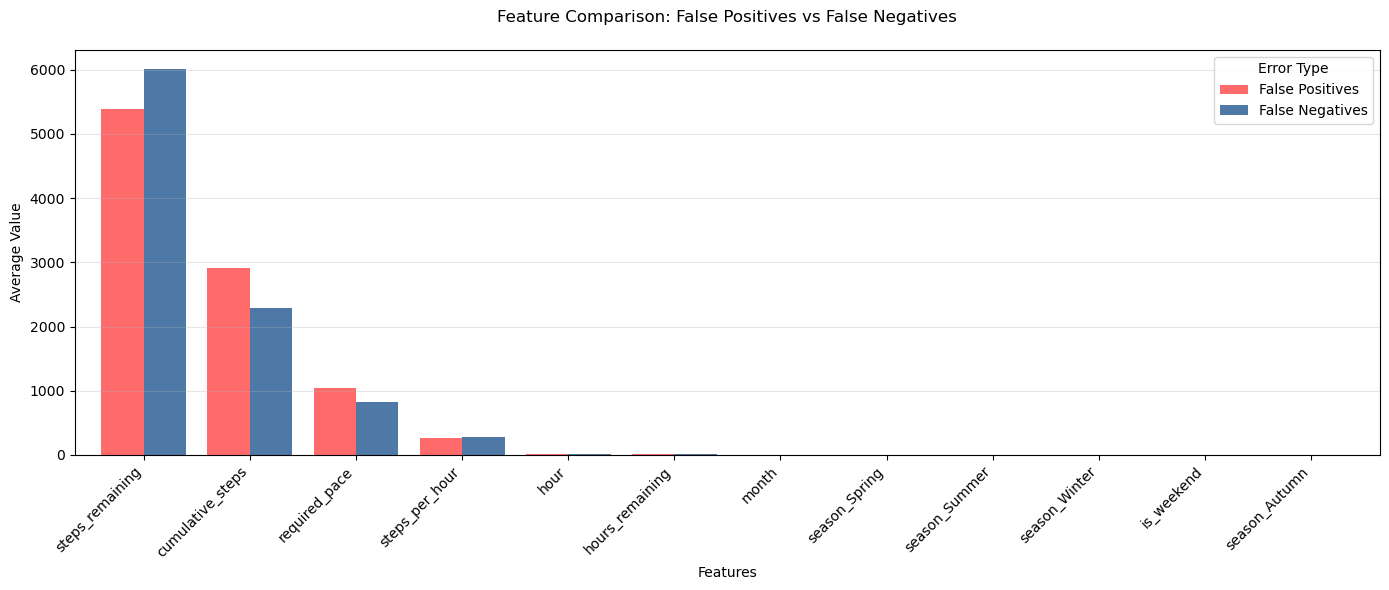

In [323]:
plot_feature_comparison(error_data['comparison_df'])

In [324]:
def plot_feature_differences(comparison_df):
    """
    Visualizes the differences between feature means for false positive and false negative predictions.

    Creates a bar chart showing the difference between average feature values for false positives
    and false negatives (FP - FN). Positive values indicate features more associated with false positives,
    while negative values indicate features more associated with false negatives.

    Parameters:
    -----------
    comparison_df : pandas.DataFrame
        DataFrame containing the feature comparison data, typically generated by setup_error_data().
        Must contain a 'Difference' column calculated as (False Positives - False Negatives).

    Returns:
    --------
    None
        Displays a matplotlib bar plot showing the directional differences between feature means.
        Bars are colored red (#FF6B6B) for positive differences and blue (#4E79A7) for negative differences.
    """
    plt.figure(figsize=(14, 6))
    comparison_df['Difference'].plot(
        kind='bar', color=np.where(comparison_df['Difference']>0, '#FF6B6B', '#4E79A7')
    )
    plt.title('Feature Differences: FP Average - FN Average', pad=20)
    plt.ylabel('Difference in Average Values')
    plt.xlabel('Features')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

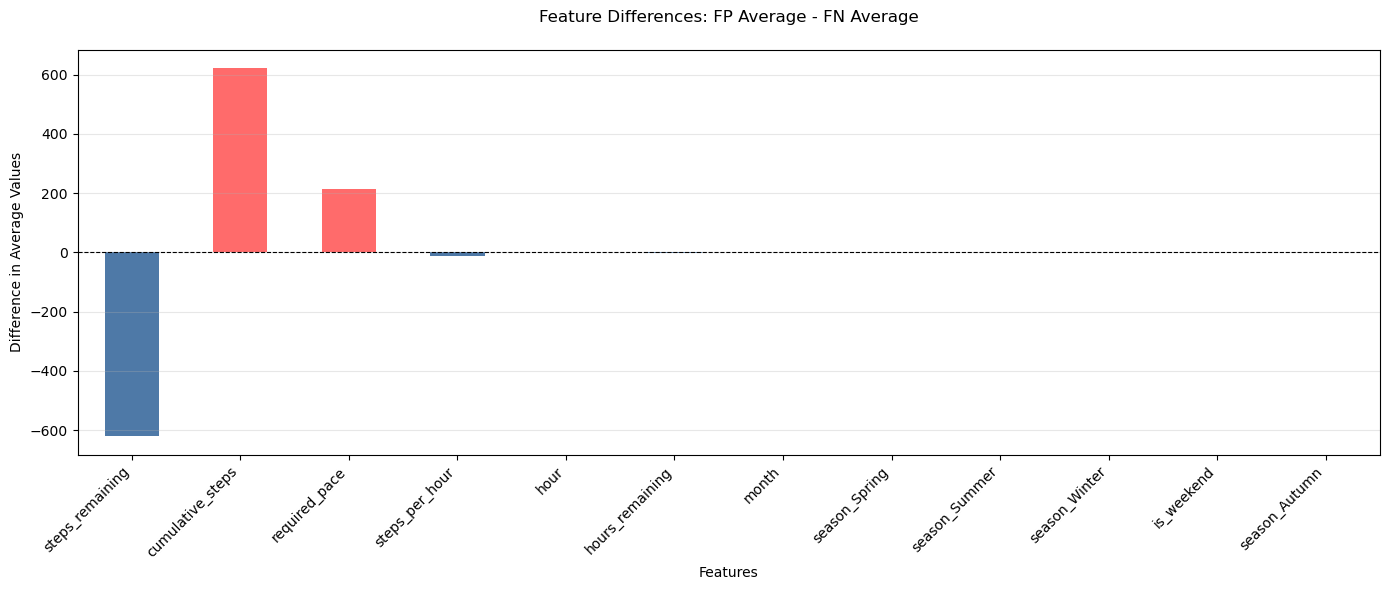

In [325]:
plot_feature_differences(error_data['comparison_df'])

In [326]:
def plot_radar_chart(comparison_df):
    """
    Visualizes the comparison between false positive and false negative patterns using a radar chart.

    Creates a radar (spider) chart that displays the relative importance of features in both types of
    misclassifications, allowing for easy visual comparison of their patterns. The chart shows two
    polygons - one for false positives (red) and one for false negatives (blue) - making it easy to
    identify which features contribute more to each error type.

    Parameters:
    -----------
    comparison_df : pandas.DataFrame
        DataFrame containing the feature comparison data, typically generated by setup_error_data().
        Must contain columns 'False Positives' and 'False Negatives' with feature means.
        The 'Difference' column (if present) will be automatically excluded from visualization.

    Returns:
    --------
    None
        Displays a matplotlib radar chart comparing the feature patterns between false positives
        and false negatives. The chart includes:
        - Two filled polygons (red for FP, blue for FN)
        - Feature names as radial labels
        - Legend identifying each error type
        - Polar grid lines for value reference
    """
    # Prepare categories (exclude 'Difference' column if present)
    categories = list(comparison_df.index)[:-1] if 'Difference' in comparison_df.columns else list(comparison_df.index)
    N = len(categories)

    # Calculate angles for radar chart axes
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    # Create polar plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Plot false positives (red)
    values = comparison_df['False Positives'][categories].values.tolist()
    values += values[:1]
    ax.plot(angles, values, color='#FF6B6B', linewidth=2, label='False Positives')
    ax.fill(angles, values, color='#FF6B6B', alpha=0.25)

    # Plot false negatives (blue)
    values = comparison_df['False Negatives'][categories].values.tolist()
    values += values[:1]
    ax.plot(angles, values, color='#4E79A7', linewidth=2, label='False Negatives')
    ax.fill(angles, values, color='#4E79A7', alpha=0.25)

    # Formatting
    ax.set_theta_offset(np.pi/2)  # Rotate plot for better readability
    ax.set_theta_direction(-1)    # Make angles increase clockwise
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)  # Add feature labels
    ax.set_rlabel_position(30)    # Position radial labels
    plt.title('Feature Pattern Comparison: FP vs FN', pad=30, fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))  # Position legend
    plt.tight_layout()
    plt.show()

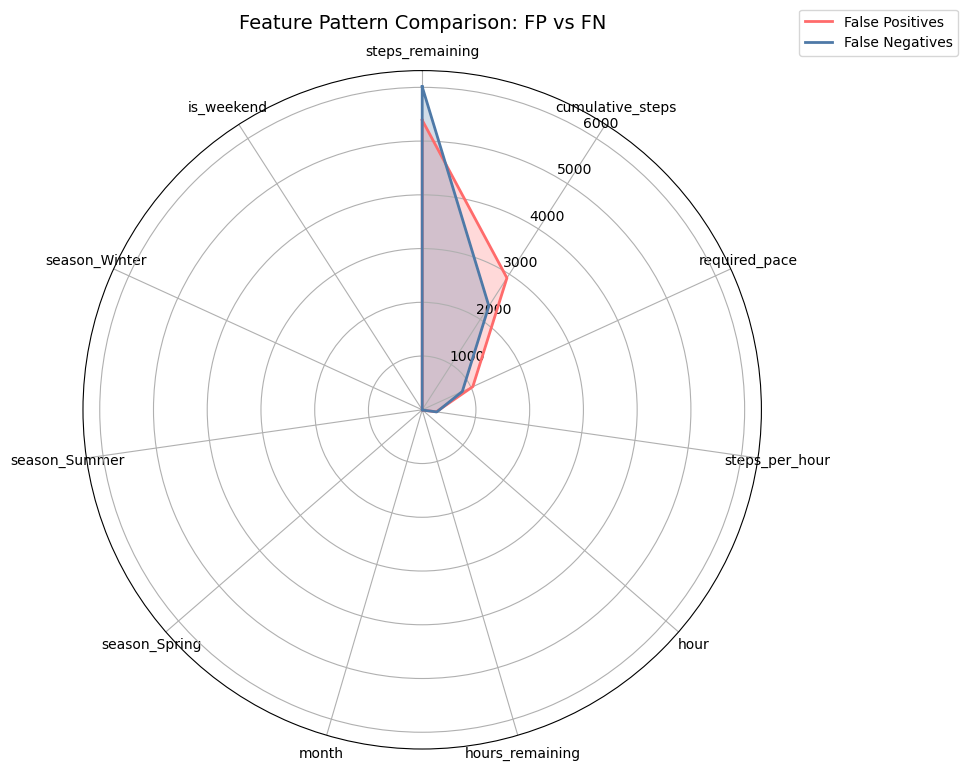

In [327]:
plot_radar_chart(error_data['comparison_df'])

In [328]:
def print_key_insights(comparison_df):
    """Print key insights from the error analysis"""
    print("\n" + "="*50)
    print("KEY INSIGHTS")
    print("="*50)
    print("1. Features with highest FP values:", list(comparison_df['False Positives'].nlargest(3).index))
    print("2. Features with highest FN values:", list(comparison_df['False Negatives'].nlargest(3).index))
    print("3. Most differentiating features:", list(comparison_df['Difference'].abs().nlargest(3).index))
    print("\nTop features with largest differences:")
    print(comparison_df['Difference'].abs().sort_values(ascending=False).head(5))

In [329]:
print_key_insights(error_data['comparison_df'])


KEY INSIGHTS
1. Features with highest FP values: ['steps_remaining', 'cumulative_steps', 'required_pace']
2. Features with highest FN values: ['steps_remaining', 'cumulative_steps', 'required_pace']
3. Most differentiating features: ['cumulative_steps', 'steps_remaining', 'required_pace']

Top features with largest differences:
cumulative_steps    621.608900
steps_remaining     621.608900
required_pace       214.215513
steps_per_hour       11.127000
month                 2.183982
Name: Difference, dtype: float64


In [330]:
# Feature importance analysis
feature_importances = model.feature_importances_
features = X_train.columns
sorted_idx = feature_importances.argsort()

print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)
for i in range(1, len(features) + 1):
    idx = sorted_idx[-i]
    print(f"{i}. {features[idx]} : {feature_importances[idx]:.4f}")


FEATURE IMPORTANCE ANALYSIS
1. cumulative_steps : 0.3112
2. steps_remaining : 0.2868
3. steps_per_hour : 0.2245
4. hours_remaining : 0.0727
5. hour : 0.0542
6. required_pace : 0.0348
7. month : 0.0104
8. season_Winter : 0.0031
9. season_Summer : 0.0014
10. season_Spring : 0.0010
11. season_Autumn : 0.0000
12. is_weekend : 0.0000


In [331]:
def plot_feature_importances(features, importances,
                            fig_size=(10, 8),
                            title='Feature Importances',
                            palette='viridis',
                            label_size=10,
                            value_format='{:.3f}'):
    """
    Displays ALL features without data loss, with anti-overlap formatting.

    Parameters:
    -----------
    features : array-like
        Feature names (e.g., X_train.columns)
    importances : array-like
        Importance scores (e.g., model.feature_importances_)
    fig_size : tuple, optional
        Figure dimensions (width, height)
    title : str, optional
        Plot title
    palette : str, optional
        Color palette name
    label_size : int, optional
        Font size for feature names
    value_format : str, optional
        Format string for importance values
    """
    # Create DataFrame
    df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values('Importance', ascending=True)

    # Create plot with corrected palette handling
    plt.figure(figsize=fig_size)
    ax = sns.barplot(
        x='Importance',
        y='Feature',
        data=df,
        hue='Feature',  # Explicitly map colors to features
        palette=palette,
        orient='h',
        dodge=False,
        saturation=0.8,
        legend=False  # Disable legend since we already have y-axis labels
    )

    # Formatting
    ax.set_title(title, pad=20, fontsize=label_size+2)
    ax.set_xlabel('Importance Score', fontsize=label_size)
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=label_size)
    ax.tick_params(axis='x', labelsize=label_size-1)

    # Add value labels
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(
            value_format.format(width),
            xy=(width, p.get_y() + p.get_height()/2),
            xytext=(3, 0),
            textcoords='offset points',
            ha='left',
            va='center',
            fontsize=label_size
        )

    ax.grid(True, axis='x', linestyle=':', alpha=0.4)
    plt.tight_layout()
    plt.show()

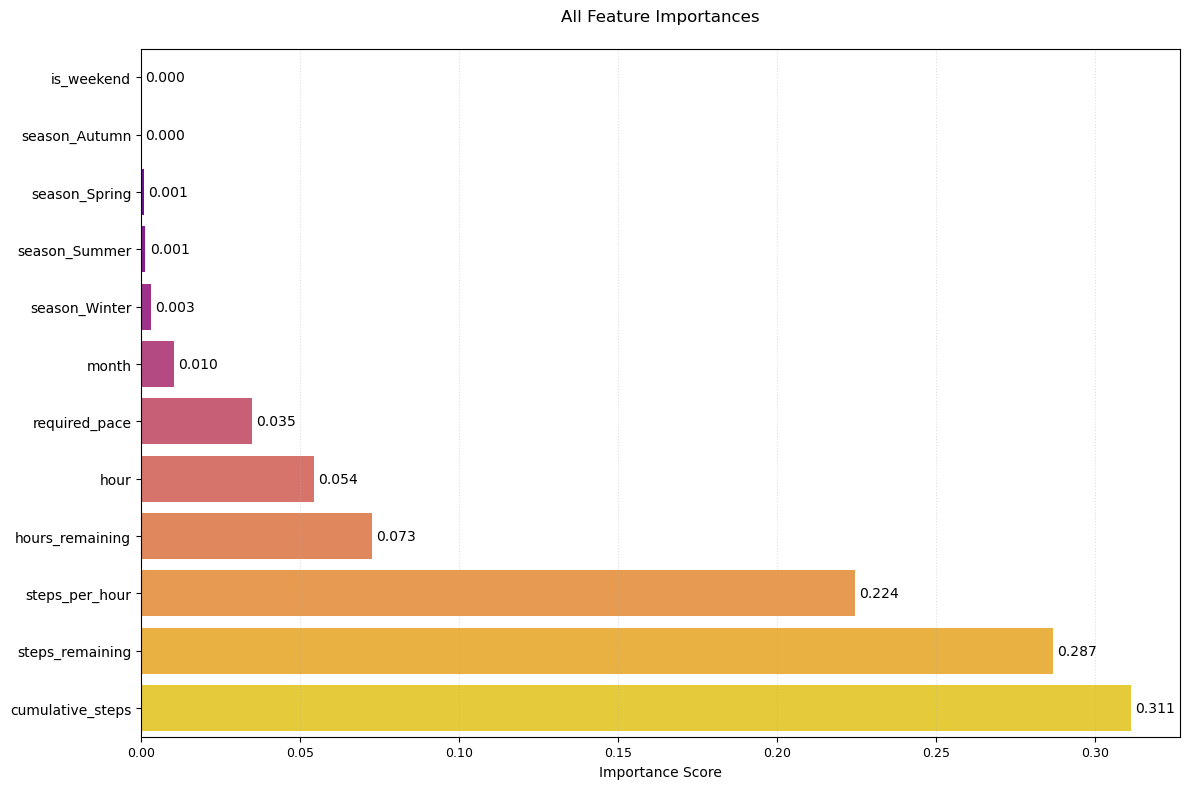

In [332]:
# Plot feature importances
plot_feature_importances(
    features=X_train.columns,
    importances=model.feature_importances_,
    title='All Feature Importances',
    palette='plasma',
    fig_size=(12, 8)
)

In [333]:
print("Model training and evaluation complete!\n")

Model training and evaluation complete!



Model Training Details:

- Algorithm: Random Forest Classifier
- Handling Class Imbalance: SMOTE oversampling
- Train-Test Split: 70-30 split by user ID
- Evaluation Metrics:
    - Accuracy: 97%
    - Precision: 92-99%
    - Recall: 97% for both classes
- Feature Importance:
    - Top 3 features account for >80% of importance:

        1. cumulative_steps (31%)

        2. steps_remaining (29%)

        3. steps_per_hour (22%)

Key Findings:

- Model performs exceptionally well at predicting step goals
- Cumulative steps is the most important predictive feature
- Time-based features (hour, hours_remaining) also contribute
- Seasonal features have minimal impact

## Step 6 : Model Comparison

In [334]:
print("STEP 6: comparing models...")

STEP 6: comparing models...


### 1. Create a model that always predicts the majority class

In [335]:
# Create baseline model that always predicts majority class
print("\nTraining baseline model...")
dummy = DummyClassifier(strategy='most_frequent')
with tqdm(total=1, desc="Baseline Model") as pbar:
    dummy.fit(X_train, y_train)
    pbar.update(1)
dummy_pred = dummy.predict(X_test)


Training baseline model...


Baseline Model:   0%|          | 0/1 [00:00<?, ?it/s]

In [336]:
# Print comparison
print("\n" + "="*50)
print("BASELINE COMPARISON (Majority Class Predictor)")
print("="*50)
print("Performance of a model that always predicts the most frequent class:")


BASELINE COMPARISON (Majority Class Predictor)
Performance of a model that always predicts the most frequent class:


In [337]:
target_names = [label_map[0], label_map[1]]
report_str = classification_report(
    y_test,
    dummy_pred,
    target_names=target_names,
    zero_division=0,
    digits=3
)
print('\n'.join([line for line in report_str.split('\n') if 'accuracy' not in line and line.strip()]))

              precision    recall  f1-score   support
 Not Reached      0.718     1.000     0.836    429729
     Reached      0.000     0.000     0.000    168771
   macro avg      0.359     0.500     0.418    598500
weighted avg      0.516     0.718     0.600    598500


In [338]:
# Calculate performance comparison
baseline_acc = dummy.score(X_test, y_test)
model_acc = accuracy_score(y_test, y_pred)
improvement = model_acc - baseline_acc

In [339]:
print("\n" + "-"*50)
print(f"{'Metric':<25} | {'Value':<10}")
print("-"*50)
print(f"{'Baseline Accuracy':<25} | {baseline_acc:.3f}")
print(f"{'Model Accuracy':<25} | {model_acc:.3f}")
print(f"{'Improvement':<25} | +{improvement:.3f}")
print("="*50 + "\n")


--------------------------------------------------
Metric                    | Value     
--------------------------------------------------
Baseline Accuracy         | 0.718
Model Accuracy            | 0.969
Improvement               | +0.251



In [340]:
print(f"Note: Baseline always predicts '{label_map[y_train.mode()[0]]}'")

Note: Baseline always predicts 'Not Reached'


### 2. Precision-Recall Comparison Bar Plot

In [341]:
def plot_model_comparison(model_metrics, dummy_metrics, class_labels, figsize=(18, 5)):
    """
    Plot side-by-side comparison of model vs baseline metrics.

    Parameters:
    -----------
    model_metrics : tuple
        (precision, recall, f1) for your model (each should be array-like with per-class scores)
    dummy_metrics : tuple
        (precision, recall, f1) for baseline model
    class_labels : list
        Names of your classes (e.g., ['Negative', 'Positive'])
    figsize : tuple, optional
        Figure dimensions (width, height) in inches
    """
    # Unpack metrics and ensure they're numpy arrays
    model_precision, model_recall, model_f1 = [np.array(x) for x in model_metrics]
    dummy_precision, dummy_recall, dummy_f1 = [np.array(x) for x in dummy_metrics]

    # Check shapes
    for name, vals in zip(['Precision', 'Recall', 'F1'],
                            [model_precision, model_recall, model_f1,
                            dummy_precision, dummy_recall, dummy_f1]):
        if vals.ndim != 1 or len(vals) != len(class_labels):
            raise ValueError(f"{name} metrics must have shape ({len(class_labels)},), got {vals.shape}")

    # Set up plot
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    metrics = ['Precision', 'Recall', 'F1-Score']
    x = np.arange(len(class_labels))
    width = 0.35

    # Plot each metric
    for i, (metric_name, model_vals, dummy_vals) in enumerate(zip(
        metrics,
        [model_precision, model_recall, model_f1],
        [dummy_precision, dummy_recall, dummy_f1]
    )):
        rects1 = ax[i].bar(x - width/2, model_vals, width, label='Model', color='#1f77b4')
        rects2 = ax[i].bar(x + width/2, dummy_vals, width, label='Baseline', color='#ff7f0e')

        ax[i].set_title(metric_name, fontsize=12)
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(class_labels)
        ax[i].legend(fontsize=10)
        ax[i].set_ylim(0, 1.1)
        ax[i].grid(axis='y', alpha=0.3)

        # Add value labels
        for rect in rects1 + rects2:
            height = rect.get_height()
            ax[i].annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom',
                            fontsize=9)

    plt.suptitle('Model vs Baseline Performance Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

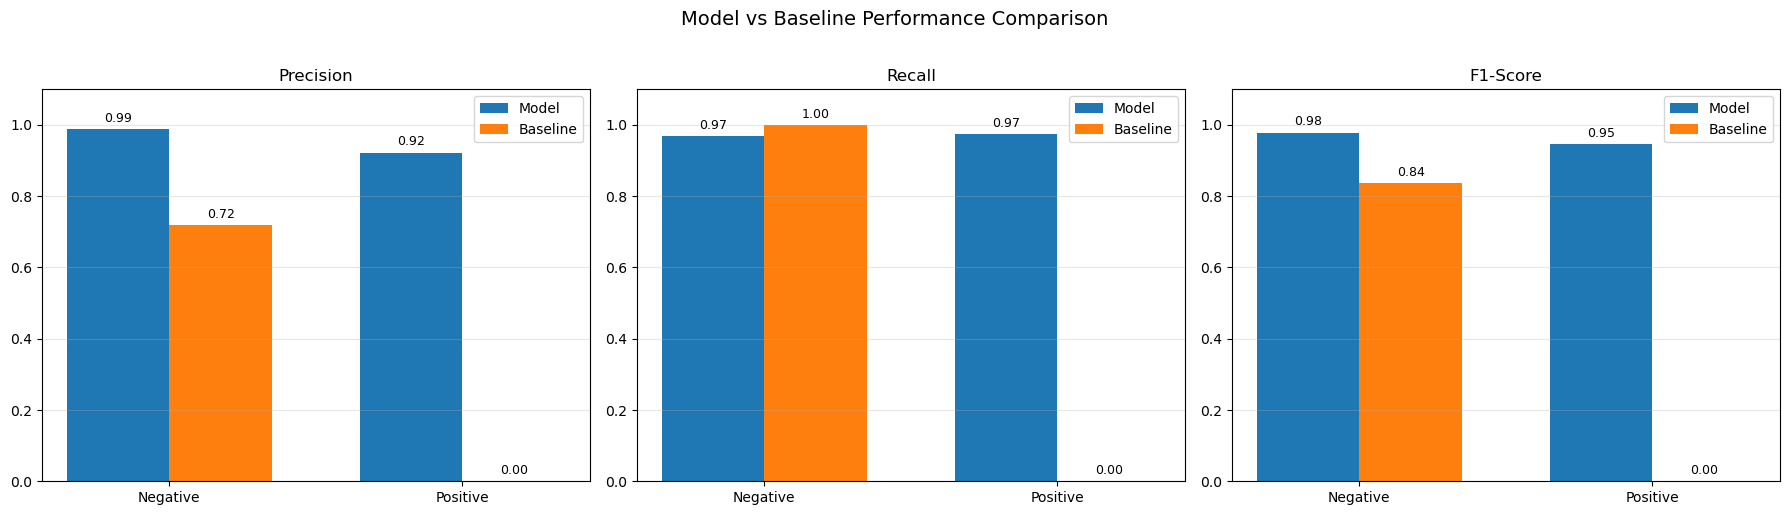

In [342]:
# Calculate per-class metrics for your model
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Calculate per-class metrics for baseline
dummy_precision = precision_score(y_test, dummy_pred, average=None, zero_division=0)
dummy_recall = recall_score(y_test, dummy_pred, average=None, zero_division=0)
dummy_f1 = f1_score(y_test, dummy_pred, average=None, zero_division=0)

# Now call the function
plot_model_comparison(
    model_metrics=(precision, recall, f1),
    dummy_metrics=(dummy_precision, dummy_recall, dummy_f1),
    class_labels=['Negative', 'Positive']
)

### 3. Accuracy Improvement Visualization

In [343]:
def plot_accuracy_comparison(y_true, y_pred, baseline_model, X_test=None,
                            labels=['Baseline', 'Model', 'Improvement'],
                            colors=['red', 'green', 'blue'],
                            figsize=(8, 5), ylim=(0, 1.1)):
    """
    Plot accuracy comparison between baseline model and your model.

    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels from your model
    baseline_model : estimator
        Trained baseline model with .score() method
    X_test : array-like, optional
        Test features (required if baseline_model needs X_test for scoring)
    labels : list, optional
        Labels for the bars (default: ['Baseline', 'Model', 'Improvement'])
    colors : list, optional
        Colors for the bars (default: ['red', 'green', 'blue'])
    figsize : tuple, optional
        Figure size (default: (8, 5))
    ylim : tuple, optional
        Y-axis limits (default: (0, 1.1))
    """
    # Calculate accuracies
    baseline_acc = baseline_model.score(X_test, y_true) if X_test is not None else baseline_model
    model_acc = accuracy_score(y_true, y_pred)
    improvement = model_acc - baseline_acc

    # Create plot
    plt.figure(figsize=figsize)
    bars = plt.bar(labels,
                    [baseline_acc, model_acc, improvement],
                    color=colors)

    # Formatting
    plt.title('Accuracy Comparison', fontsize=14, pad=15)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(*ylim)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

    plt.tight_layout()
    plt.show()

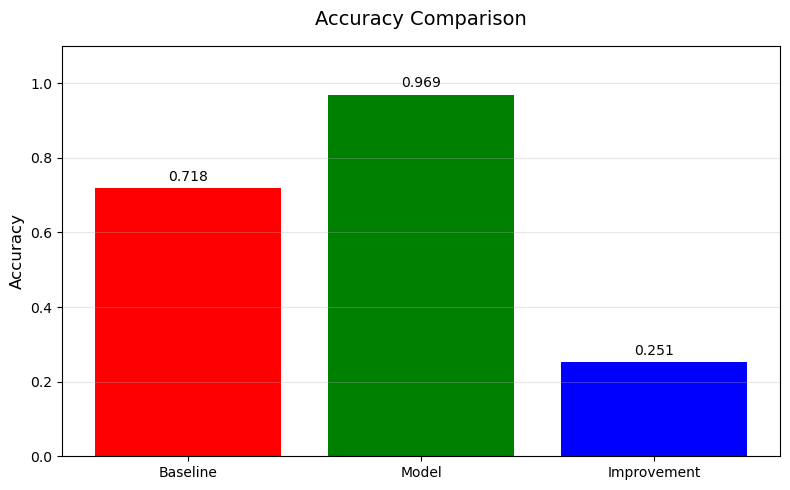

In [344]:
dummy_accuracy = dummy.score(X_test, y_test)
plot_accuracy_comparison(y_test, y_pred, dummy_accuracy)

### 4. Confusion Matrix Comparison

In [345]:
def plot_confusion_matrix_comparison(y_test, y_pred, dummy_pred, label_map, figsize=(12, 5)):
    """
    Plots side-by-side confusion matrices for a model and a baseline model.

    Parameters:
    - y_test: True labels
    - y_pred: Model's predictions
    - dummy_pred: Baseline model's predictions
    - label_map: Dictionary mapping class indices to label names
    - figsize: Tuple specifying figure size (default: (12, 5))
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Model's confusion matrix
    cm_model = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm_model, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=[f'Pred {label_map[0]}', f'Pred {label_map[1]}'],
                yticklabels=[f'True {label_map[0]}', f'True {label_map[1]}'])
    ax1.set_title('Model')

    # Baseline model's confusion matrix
    cm_dummy = confusion_matrix(y_test, dummy_pred)
    sns.heatmap(cm_dummy, annot=True, fmt='d', cmap='Reds', ax=ax2,
                xticklabels=[f'Pred {label_map[0]}', f'Pred {label_map[1]}'],
                yticklabels=[f'True {label_map[0]}', f'True {label_map[1]}'])
    ax2.set_title('Baseline Model')

    plt.suptitle('Confusion Matrix Comparison')
    plt.tight_layout()
    plt.show()

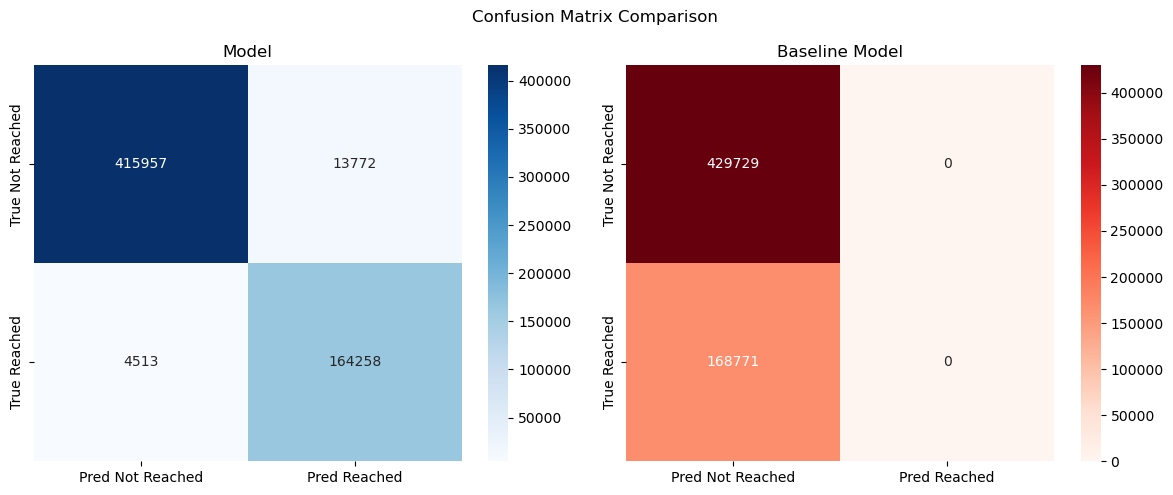

In [346]:
plot_confusion_matrix_comparison(
    y_test=y_test,
    y_pred=y_pred,
    dummy_pred=dummy_pred,
    label_map={0: label_map[0], 1: label_map[1]}
)

### 5. ROC Curve Comparison

In [347]:
def plot_roc_comparison(y_test, model, dummy_model, X_test, figsize=(8, 6)):
    """
    Plots ROC curves comparing the model against a baseline model.

    Parameters:
    - y_test: True labels
    - model: Your trained model (must have predict_proba method)
    - dummy_model: Your baseline model (must have predict_proba method)
    - X_test: Test features
    - figsize: Tuple specifying figure size (default: (8, 6))
    """
    try:
        # Get probabilities for positive class
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # ROC Curve for main model
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # ROC Curve for dummy model
        dummy_proba = np.full_like(y_test, dummy_model.predict_proba(X_test)[0, 1])
        dummy_fpr, dummy_tpr, _ = roc_curve(y_test, dummy_proba)
        dummy_auc = auc(dummy_fpr, dummy_tpr)

        # Plotting
        plt.figure(figsize=figsize)
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'Model (AUC = {roc_auc:.2f})')
        plt.plot(dummy_fpr, dummy_tpr, color='blue', lw=2, linestyle='--',
                label=f'Baseline (AUC = {dummy_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

    except AttributeError:
        print("ROC curve not available - model needs to have predict_proba method")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.9s


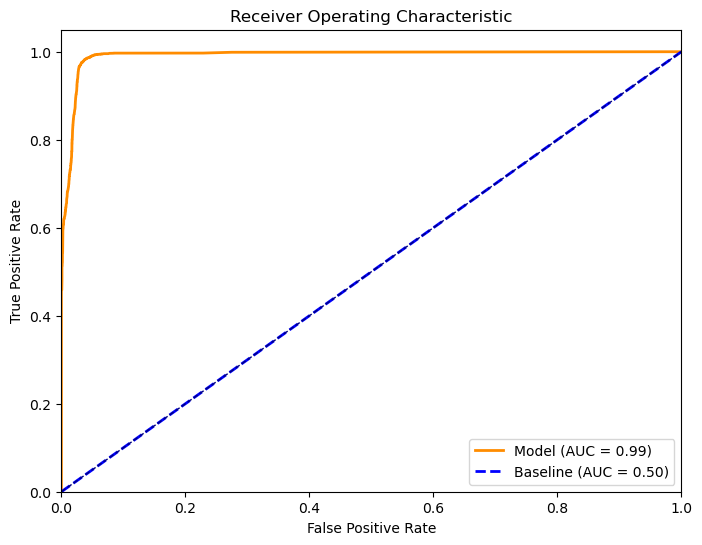

In [348]:
plot_roc_comparison(
    y_test=y_test,
    model=model,
    dummy_model=dummy,
    X_test=X_test
)

### 6. Precision-Recall Curve Comparison

In [349]:
def plot_pr_comparison(y_test, model, dummy_model, X_test, figsize=(8, 6)):
    """
    Plots Precision-Recall curves comparing the model against a baseline model.

    Parameters:
    - y_test: True labels (array-like)
    - model: Your trained classifier with predict_proba() method
    - dummy_model: Your baseline classifier with predict_proba() method
    - X_test: Test features (array-like)
    - figsize: Figure size (default: (8, 6))
    """
    try:
        # Get probabilities for positive class
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        dummy_proba = np.full_like(y_test, dummy_model.predict_proba(X_test)[0, 1])

        # Precision-Recall curve for Model
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)

        # Precision-Recall curve for dummy model
        dummy_precision, dummy_recall, _ = precision_recall_curve(y_test, dummy_proba)
        dummy_pr_auc = auc(dummy_recall, dummy_precision)

        # Plotting
        plt.figure(figsize=figsize)
        plt.plot(recall, precision, color='darkorange', lw=2,
                label=f'Model (AUC = {pr_auc:.2f})')
        plt.plot(dummy_recall, dummy_precision, color='blue', lw=2, linestyle='--',
                label=f'Baseline (AUC = {dummy_pr_auc:.2f})')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="upper right")
        plt.show()

    except AttributeError:
        print("PR curve not available - models need predict_proba() method")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.7s


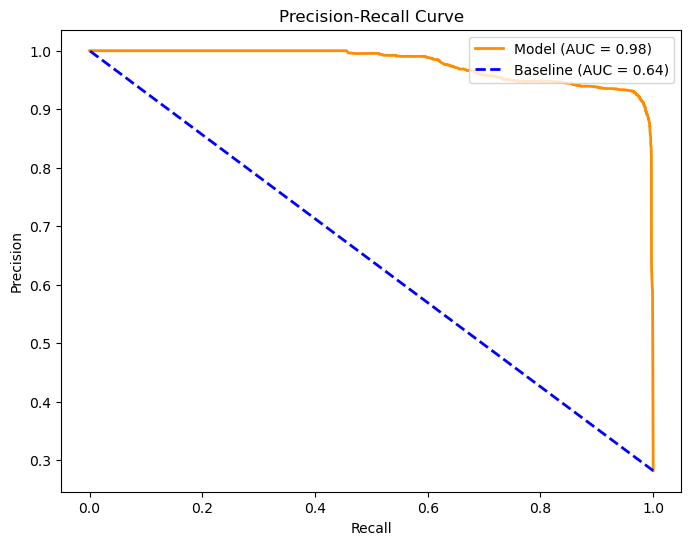

In [350]:
plot_pr_comparison(
    y_test=y_test,
    model=model,
    dummy_model=dummy,
    X_test=X_test
)

### 7. Class Distribution and Prediction Comparison

In [351]:
def plot_class_distribution_comparison(y_test, y_pred, dummy_pred, label_map, figsize=(10, 6)):
    """
    Plots a comparison of actual vs predicted class distributions between model and baseline.

    Parameters:
    - y_test: True labels (array-like)
    - y_pred: Model predictions (array-like)
    - dummy_pred: Baseline model predictions (array-like)
    - label_map: Dictionary mapping class indices to label names (e.g., {0: 'Negative', 1: 'Positive'})
    - figsize: Figure size (default: (10, 6))
    """
    # Prepare the data
    total = len(y_test)
    data = pd.DataFrame({
        'Class': [label_map[0], label_map[1]] * 3,
        'Count': [
            sum(y_test == 0), sum(y_test == 1),  # Actual counts
            sum(y_pred == 0), sum(y_pred == 1),  # Model predictions
            sum(dummy_pred == 0), sum(dummy_pred == 1)  # Baseline predictions
        ],
        'Type': ['Actual']*2 + ['Model']*2 + ['Baseline']*2
    })

    # Calculate percentages
    data['Percentage'] = (data['Count'] / total * 100).round(1)

    # Print the dataframe
    print("Class Distribution Data:")
    print(data.to_string(index=False))
    print("\n")

    # Create the plot
    plt.figure(figsize=figsize)
    palette = {'Actual': 'blue', 'Model': 'green', 'Baseline': 'red'}
    ax = sns.barplot(x='Class', y='Count', hue='Type', data=data, palette=palette)

    # Add value labels, including for 0%
    for (class_name, type_name, count, percentage) in zip(data['Class'], data['Type'], data['Count'], data['Percentage']):
        # Find the X position of the bar group for this class
        x_positions = list(data['Class']).index(class_name)  # 0 for first class, 1 for second class

        offset = 0.27
        # Find the exact position based on Type (Actual, Model, Baseline)
        type_offset = {'Actual': -offset, 'Model': 0, 'Baseline': offset}
        x = x_positions + type_offset[type_name]

        # Place the annotation
        ax.annotate(f"{count} | {percentage}%",
                    (x, max(count, 0.1)),  # max(count, 0.1) to ensure 0 is visible
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=10)

    plt.title('Comparison of Actual vs Predicted Class Distributions')
    plt.ylabel('Count')
    plt.xlabel('Class')
    plt.legend(title='Distribution Type')
    plt.tight_layout()
    plt.show()

Class Distribution Data:
      Class  Count     Type  Percentage
Not Reached 429729   Actual        71.8
    Reached 168771   Actual        28.2
Not Reached 420470    Model        70.3
    Reached 178030    Model        29.7
Not Reached 598500 Baseline       100.0
    Reached      0 Baseline         0.0




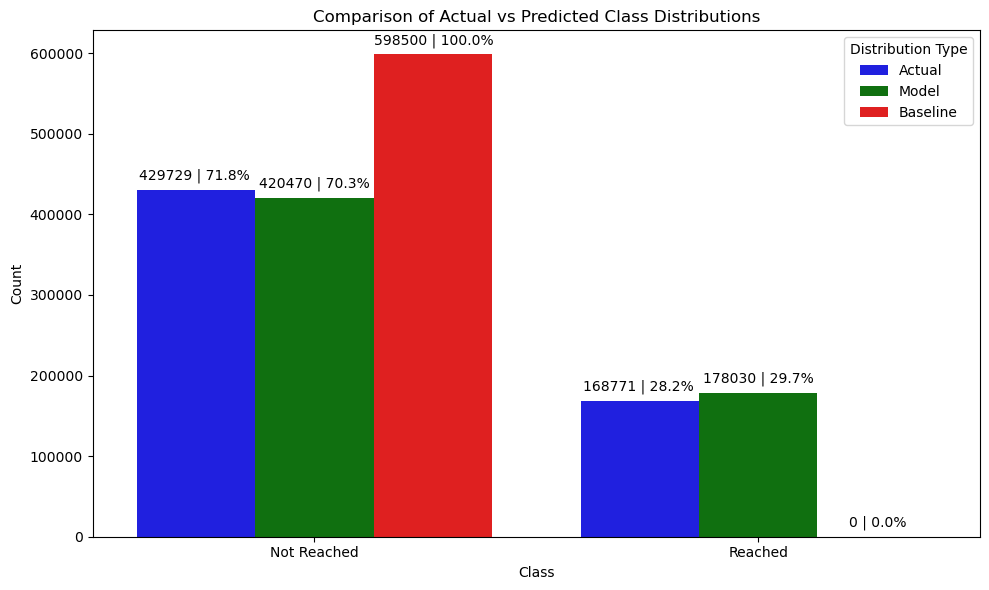

In [352]:
plot_class_distribution_comparison(
    y_test=y_test,
    y_pred=y_pred,
    dummy_pred=dummy_pred,
    label_map={0: label_map[0], 1: label_map[1]}
)

In [353]:
def plot_stacked_class_distribution(y_test, y_pred, dummy_pred, label_map, figsize=(12, 6)):
    """
    Plots a stacked bar chart comparing actual vs predicted class distributions.

    Parameters:
    - y_test: True labels (array-like)
    - y_pred: Model predictions (array-like)
    - dummy_pred: Baseline model predictions (array-like)
    - label_map: Dictionary mapping class indices to label names (e.g., {0: 'Negative', 1: 'Positive'})
    - figsize: Figure size (default: (12, 6))
    """
    # Prepare the data
    total = len(y_test)
    data = pd.DataFrame({
        'Class': [label_map[0], label_map[1]] * 3,
        'Count': [
            sum(y_test == 0), sum(y_test == 1),  # Actual counts
            sum(y_pred == 0), sum(y_pred == 1),  # Model predictions
            sum(dummy_pred == 0), sum(dummy_pred == 1)  # Baseline predictions
        ],
        'Type': ['Actual']*2 + ['Model']*2 + ['Baseline']*2
    })

    # Pivot the data for stacked plot
    pivot_data = data.pivot(index='Type', columns='Class', values='Count')

    # Create the plot
    ax = pivot_data.plot(kind='bar', stacked=True, figsize=figsize,
                        color=['tab:blue', 'tab:orange'],
                        edgecolor='white', linewidth=0.5)

    # Add value labels
    for container in ax.containers:
        for p in container:
            width, height = p.get_width(), p.get_height()
            if height > 0:
                x, y = p.get_xy()
                ax.text(x + width/2, y + height/2,
                        f"{int(height)} | {height/total*100:.1f}%",
                        ha='center', va='center',
                        color='white' if height > total*0.3 else 'black')

    plt.title('Stacked Class Distribution: Actual vs Predictions', pad=20)
    plt.ylabel('Count')
    plt.xlabel('')
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

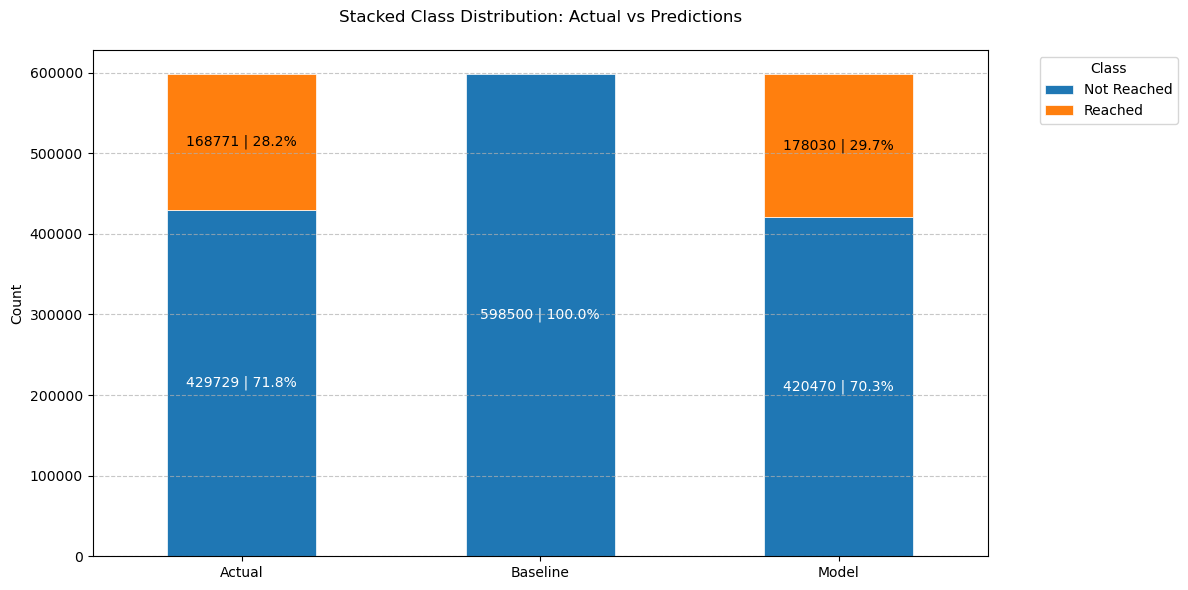

In [354]:
plot_stacked_class_distribution(
    y_test=y_test,
    y_pred=y_pred,
    dummy_pred=dummy_pred,
    label_map={0: label_map[0], 1: label_map[1]}
)

In [355]:
print("Model comparison finished!\n")

Model comparison finished!



Comparison Insights:

- Baseline accuracy: 71.8% (always predicting "Not Reached")
- Model accuracy: 96.9% (+25.1% improvement)
- Model significantly outperforms baseline on all metrics
- ROC AUC: 0.99 (model) vs 0.50 (baseline)
- PR AUC: 0.98 (model) vs 0.28 (baseline)

## Step 7: Prediction Function

In [356]:
print("STEP 7: Creating prediction function...")

STEP 7: Creating prediction function...


In [364]:
def predict_for_user():
    """Interactive function to predict step goal achievement"""
    print("\nPredict whether you will reach your daily step goal:")

    try:
        # Get user input (commented out for this demo)
        current_date = "2024-04-12" # input("\nEnter current date (YYYY-MM-DD): ")
        current_time = "12:45" # input("Enter current time (HH:MM): ")
        current_steps = 500.0 #float(input("Current cumulative steps: "))

        # Parse inputs
        hour = int(current_time.split(':')[0])
        if hour < 0 or hour > 23:
            raise ValueError("Hour must be between 0 and 23")
        if current_steps < 0:
            raise ValueError("Steps must be positive")

        # Calculate features
        date_obj = pd.to_datetime(current_date)
        season = get_season(date_obj)
        is_weekend = date_obj.weekday() >= 5

        # Create feature vector
        user_data = pd.DataFrame({
            'hour': [hour],
            'is_weekend': [int(is_weekend)],
            'cumulative_steps': [current_steps],
            'steps_per_hour': [current_steps / (hour + 1)],
            'steps_remaining': [(overall_avg_steps * 60 * 24) - current_steps],
            'hours_remaining': [18 - hour],
            'required_pace': [((overall_avg_steps * 60 * 24) - current_steps) / (18 - hour + 0.1)],
            'season_Spring': [1 if season == 'Spring' else 0],
            'season_Summer': [1 if season == 'Summer' else 0],
            'season_Autumn': [1 if season == 'Autumn' else 0],
            'season_Winter': [1 if season == 'Winter' else 0],
            'month': [date_obj.month]
        })

        # Make prediction
        proba = model.predict_proba(user_data[features])[0][1]

        # Calculate goal metrics
        daily_goal = overall_avg_steps * 60 * 24
        progress_ratio = current_steps / daily_goal
        time_ratio = hour / 18

        # Dynamic prediction threshold
        prediction_threshold = 0.5 - (0.3 * (1 - time_ratio))
        prediction = proba >= prediction_threshold

        # Print prediction
        print(f"\nPrediction for {current_date} at {current_time}:")
        print(f"- Current: {current_steps:.0f}/{daily_goal:.0f} ({progress_ratio:.1%})")
        print(f"- Time elapsed: {time_ratio:.1%} of day")
        print(f"- Prediction: {'WILL REACH' if prediction else 'WILL NOT REACH'}")
        print(f"- Confidence: {proba:.1%}")

        # Provide recommendations if time remains
        if hour < 18:
            remaining_hours = 18 - hour
            needed_steps = max(daily_goal - current_steps, 0)
            if remaining_hours > 0:
                hourly_pace = needed_steps / remaining_hours
                print(f"\nTo reach your goal by 18:00:")
                print(f"- Needed: {needed_steps:.0f} more steps")
                print(f"- Required pace: {hourly_pace:.0f} steps/hour")

                # Activity recommendations based on required pace
                if hourly_pace > 1500:
                    print("- Activity suggestion: Vigorous walk + jogging")
                elif hourly_pace > 1000:
                    print("- Activity suggestion: Brisk walking")
                else:
                    print("- Activity suggestion: Leisurely walking")

    except Exception as e:
        print(f"\nError: {str(e)}")
        print("Please try again with valid inputs.")

In [365]:
# Run prediction interface
print("\nStep Goal Prediction System")
print("---------------------------")
print(f"Based on average goal: {overall_avg_steps * 60 * 24:.0f} steps per day")
predict_for_user()

print("\nAnalysis complete!")


Step Goal Prediction System
---------------------------
Based on average goal: 8307 steps per day

Predict whether you will reach your daily step goal:

Prediction for 2024-04-12 at 12:45:
- Current: 500/8307 (6.0%)
- Time elapsed: 66.7% of day
- Prediction: WILL NOT REACH
- Confidence: 0.0%

To reach your goal by 18:00:
- Needed: 7807 more steps
- Required pace: 1301 steps/hour
- Activity suggestion: Brisk walking

Analysis complete!


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
